# Data Leakage 문제 존재하면 shuffle 시켜도 나중에 Case랑 Date별로 다시 정렬시켜주는 코드 쓰면 됨

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install filterpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177 kB 4.8 MB/s 
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110474 sha256=31b3bc17874e4bb53ecde3356b173fb3930185e5f2483686bbf2782403ede409
  Stored in directory: /root/.cache/pip/wheels/fe/f6/cb/40331472edf4fd399b8cad02973c6acbdf26898342928327fe
Successfully built filterpy


In [3]:
import random
import pandas as pd
import numpy as np
import os
import glob
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
from tqdm import tqdm

In [128]:
def preprocessing(input_path):
  all_input_list = sorted(glob.glob(input_path))
  train = pd.DataFrame()
  for datapath in all_input_list:
    data = pd.read_csv(datapath) # 이게 지금 28일치 * 24시
    data['obs_time'] = data.index % 24 # 시간통일
    print(data)
    data = abs(data)
    col_list = data.columns
    for i in range(0,len(col_list)):
      col = col_list[i]    
      if '누적' in col :
        data[col] = data.groupby((data.obs_time == 0).cumsum()).agg(col_list[i-1]).cumsum()
    data.to_csv(datapath,index=False)
    train = pd.concat([train,data])
  return train
input_path_train = '/content/drive/MyDrive/상추/original_data/train_input/*.csv'
input_path_test = '/content/drive/MyDrive/상추/original_data/test_input/*.csv'

preprocessing(input_path_train)
preprocessing(input_path_test)

     DAT  obs_time    내부온도관측치    내부습도관측치      co2관측치     ec관측치  시간당분무량  \
0      0         0  25.300000  81.835000  536.016667  1.407439     0.0   
1      0         1  25.680357  81.264286  528.696429  1.409003   126.0   
2      0         2  25.273333  81.471666  532.833333  1.406913     0.0   
3      0         3  25.355000  81.398334  545.566667  1.406689   126.0   
4      0         4  25.391667  81.483333  558.583333  1.411070     0.0   
..   ...       ...        ...        ...         ...       ...     ...   
667   27        19  30.880000  82.255000  464.433333  0.000000   252.0   
668   27        20  29.068333  82.506667  534.633333  0.000000   126.0   
669   27        21  28.246667  82.835000  563.433333  0.000000     0.0   
670   27        22  28.005000  82.850000  577.150000  0.000000   126.0   
671   27        23  27.868333  82.453333  588.616667  0.000000     0.0   

     일간누적분무량   시간당백색광량   일간누적백색광량  시간당적색광량   일간누적적색광량  시간당청색광량  일간누적청색광량  \
0       0.00      0.00       0.00  

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량
0,0,0,26.260000,60.103333,471.883333,1.028971,0.00,0.00,0.0000,0.0000,0.0,0.0000,0.0,0.000,0.0000,0.0000
1,0,1,26.511864,59.930509,472.500000,1.030566,769.00,769.00,0.0000,0.0000,0.0,0.0000,0.0,0.000,0.0000,0.0000
2,0,2,25.890000,59.745000,472.850000,1.034274,0.00,769.00,0.0000,0.0000,0.0,0.0000,0.0,0.000,0.0000,0.0000
3,0,3,25.871666,60.023334,476.666667,1.034595,769.00,1538.00,0.0000,0.0000,0.0,0.0000,0.0,0.000,0.0000,0.0000
4,0,4,26.356667,60.150000,468.833333,1.035417,0.00,1538.00,0.0000,0.0000,0.0,0.0000,0.0,0.000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,27,19,24.478333,59.196667,442.383333,0.916185,0.00,2594.56,6.1882,146712.9397,0.0,22242.1668,0.0,10457.954,6.1882,179413.0605
668,27,20,24.636667,58.330000,439.733333,0.916925,80.99,2675.55,0.0000,146712.9397,0.0,22242.1668,0.0,10457.954,0.0000,179413.0605
669,27,21,24.103333,57.768333,434.516667,0.916777,0.00,2675.55,0.0000,146712.9397,0.0,22242.1668,0.0,10457.954,0.0000,179413.0605
670,27,22,23.888333,57.255000,427.633333,0.918006,126.00,2801.55,0.0000,146712.9397,0.0,22242.1668,0.0,10457.954,0.0000,179413.0605


In [200]:
train_input_list = sorted(glob.glob('/content/drive/MyDrive/상추/original_data/train_input/*.csv'))
train_target_list = sorted(glob.glob('/content/drive/MyDrive/상추/original_data/train_target/*.csv'))

test_input_list = sorted(glob.glob('/content/drive/MyDrive/상추/original_data/test_input/*.csv'))
test_target_list = sorted(glob.glob('/content/drive/MyDrive/상추/original_data/test_target/*.csv'))
def make_dataset(all_input_list, all_target_list):
    df_all = pd.DataFrame()
    length = len(all_input_list)
    for idx in range(length):
        X = pd.read_csv(all_input_list[idx])
        y = pd.read_csv(all_target_list[idx])
        y['DAT'] = y['DAT']-1
        df_concat = pd.merge(X, y, on='DAT', how='left')
        df_concat['Case'] = idx+1
        df_all = pd.concat([df_all, df_concat])
    return df_all

train = make_dataset(train_input_list, train_target_list)
test = make_dataset(test_input_list, test_target_list)

In [201]:
train

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량,predicted_weight_g,Case
0,0,0,25.300000,81.835000,536.016667,1.407439,0.0,0.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000,0.167719,1
1,0,1,25.680357,81.264286,528.696429,1.409003,126.0,126.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000,0.167719,1
2,0,2,25.273333,81.471666,532.833333,1.406913,0.0,126.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000,0.167719,1
3,0,3,25.355000,81.398334,545.566667,1.406689,126.0,252.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000,0.167719,1
4,0,4,25.391667,81.483333,558.583333,1.411070,0.0,252.00,0.0000,0.000,0.0,0.0000,0.0,0.0000,0.0000,0.0000,0.167719,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,27,19,26.030000,58.736667,448.500000,1.195415,0.0,2543.12,12.3764,146722.222,0.0,22253.7504,0.0,10462.6535,12.3764,179438.6259,86.591508,28
668,27,20,27.341666,58.373334,449.183333,1.190780,126.0,2669.12,0.0000,146722.222,0.0,22253.7504,0.0,10462.6535,0.0000,179438.6259,86.591508,28
669,27,21,27.785000,58.711667,441.933333,1.185593,0.0,2669.12,0.0000,146722.222,0.0,22253.7504,0.0,10462.6535,0.0000,179438.6259,86.591508,28
670,27,22,28.480000,58.121667,437.600000,1.179664,0.0,2669.12,0.0000,146722.222,0.0,22253.7504,0.0,10462.6535,0.0000,179438.6259,86.591508,28


In [202]:
train['내부온도관측치'][train['내부온도관측치'] == 0] = train['내부온도관측치'].mean()

<ipython-input-202-a3a709d65087>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['내부온도관측치'][train['내부온도관측치'] == 0] = train['내부온도관측치'].mean()


In [203]:
train['내부습도관측치'][train['내부습도관측치'] == 0] = train['내부습도관측치'].mean()
train['내부습도관측치'][train['내부습도관측치'] == 0]

<ipython-input-203-e5bc6e872e71>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['내부습도관측치'][train['내부습도관측치'] == 0] = train['내부습도관측치'].mean()


Series([], Name: 내부습도관측치, dtype: float64)

In [204]:
train['05시내부온도관측치누적'] = 0
train['19시내부온도관측치누적'] = 0
train['23시내부온도관측치누적'] = 0

train['05시내부습도관측치누적'] = 0
train['19시내부습도관측치누적'] = 0
train['23시내부습도관측치누적'] = 0

train['05시co2관측치누적'] = 0
train['19시co2관측치누적'] = 0
train['23시co2관측치누적'] = 0

train['05시ec관측치누적'] = 0
train['19시ec관측치누적'] = 0
train['23시ec관측치누적'] = 0

train['05시분무량누적'] = 0
train['19시분무량누적'] = 0
train['23시분무량누적'] = 0

train['05시백색광누적'] = 0
train['19시백색광누적'] = 0
train['23시백색광누적'] = 0

train['05시적색광누적'] = 0
train['19시적색광누적'] = 0
train['23시적색광누적'] = 0

train['05시청색광누적'] = 0
train['19시청색광누적'] = 0
train['23시청색광누적'] = 0

train['05시총광량누적'] = 0
train['19시총광량누적'] = 0
train['23시총광량누적'] = 0



test['05시내부온도관측치누적'] = 0
test['19시내부온도관측치누적'] = 0
test['23시내부온도관측치누적'] = 0

test['05시내부습도관측치누적'] = 0
test['19시내부습도관측치누적'] = 0
test['23시내부습도관측치누적'] = 0

test['05시co2관측치누적'] = 0
test['19시co2관측치누적'] = 0
test['23시co2관측치누적'] = 0

test['05시ec관측치누적'] = 0
test['19시ec관측치누적'] = 0
test['23시ec관측치누적'] = 0

test['05시분무량누적'] = 0
test['19시분무량누적'] = 0
test['23시분무량누적'] = 0

test['05시백색광누적'] = 0
test['19시백색광누적'] = 0
test['23시백색광누적'] = 0

test['05시적색광누적'] = 0
test['19시적색광누적'] = 0
test['23시적색광누적'] = 0

test['05시청색광누적'] = 0
test['19시청색광누적'] = 0
test['23시청색광누적'] = 0

test['05시총광량누적'] = 0
test['19시총광량누적'] = 0
test['23시총광량누적'] = 0

train

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,...,23시백색광누적,05시적색광누적,19시적색광누적,23시적색광누적,05시청색광누적,19시청색광누적,23시청색광누적,05시총광량누적,19시총광량누적,23시총광량누적
0,0,0,25.300000,81.835000,536.016667,1.407439,0.0,0.00,0.0000,0.000,...,0,0,0,0,0,0,0,0,0,0
1,0,1,25.680357,81.264286,528.696429,1.409003,126.0,126.00,0.0000,0.000,...,0,0,0,0,0,0,0,0,0,0
2,0,2,25.273333,81.471666,532.833333,1.406913,0.0,126.00,0.0000,0.000,...,0,0,0,0,0,0,0,0,0,0
3,0,3,25.355000,81.398334,545.566667,1.406689,126.0,252.00,0.0000,0.000,...,0,0,0,0,0,0,0,0,0,0
4,0,4,25.391667,81.483333,558.583333,1.411070,0.0,252.00,0.0000,0.000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,27,19,26.030000,58.736667,448.500000,1.195415,0.0,2543.12,12.3764,146722.222,...,0,0,0,0,0,0,0,0,0,0
668,27,20,27.341666,58.373334,449.183333,1.190780,126.0,2669.12,0.0000,146722.222,...,0,0,0,0,0,0,0,0,0,0
669,27,21,27.785000,58.711667,441.933333,1.185593,0.0,2669.12,0.0000,146722.222,...,0,0,0,0,0,0,0,0,0,0
670,27,22,28.480000,58.121667,437.600000,1.179664,0.0,2669.12,0.0000,146722.222,...,0,0,0,0,0,0,0,0,0,0


In [205]:
train = train.drop(train.filter(regex='일간누적').columns, axis=1)
test = test.drop(test.filter(regex='일간누적').columns, axis=1)
train #관측치에 칼만필터 씌워볼까?

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,시간당백색광량,시간당적색광량,시간당청색광량,...,23시백색광누적,05시적색광누적,19시적색광누적,23시적색광누적,05시청색광누적,19시청색광누적,23시청색광누적,05시총광량누적,19시총광량누적,23시총광량누적
0,0,0,25.300000,81.835000,536.016667,1.407439,0.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,25.680357,81.264286,528.696429,1.409003,126.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0,2,25.273333,81.471666,532.833333,1.406913,0.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0,3,25.355000,81.398334,545.566667,1.406689,126.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0,4,25.391667,81.483333,558.583333,1.411070,0.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,27,19,26.030000,58.736667,448.500000,1.195415,0.0,12.3764,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
668,27,20,27.341666,58.373334,449.183333,1.190780,126.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
669,27,21,27.785000,58.711667,441.933333,1.185593,0.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
670,27,22,28.480000,58.121667,437.600000,1.179664,0.0,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [206]:
train_new = train
test_new = test

In [207]:
train['시간대'] = 0
train['시간대'][(train['obs_time'] >= 0) & (train['obs_time'] <= 5)] = 1
train['시간대'][(train['obs_time'] > 5) & (train['obs_time'] < 20)] = 2
train['시간대'][(train['obs_time'] >= 20) & (train['obs_time'] <= 23)] = 3

test['시간대'] = 0
test['시간대'][(test['obs_time'] >= 0) & (test['obs_time'] <= 5)] = 1
test['시간대'][(test['obs_time'] > 5) & (test['obs_time'] < 20)] = 2
test['시간대'][(test['obs_time'] >= 20) & (test['obs_time'] <= 23)] = 3

test

<ipython-input-207-cb022eb2c26f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['시간대'][(train['obs_time'] >= 0) & (train['obs_time'] <= 5)] = 1
<ipython-input-207-cb022eb2c26f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['시간대'][(train['obs_time'] > 5) & (train['obs_time'] < 20)] = 2
<ipython-input-207-cb022eb2c26f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['시간대'][(train['obs_time'] >= 20) & (train['obs_t

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,시간당백색광량,시간당적색광량,시간당청색광량,...,05시적색광누적,19시적색광누적,23시적색광누적,05시청색광누적,19시청색광누적,23시청색광누적,05시총광량누적,19시총광량누적,23시총광량누적,시간대
0,0,0,26.260000,60.103333,471.883333,1.028971,0.00,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,0,1,26.511864,59.930509,472.500000,1.030566,769.00,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,0,2,25.890000,59.745000,472.850000,1.034274,0.00,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,0,3,25.871666,60.023334,476.666667,1.034595,769.00,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,0,4,26.356667,60.150000,468.833333,1.035417,0.00,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,27,19,24.478333,59.196667,442.383333,0.916185,0.00,6.1882,0.0,0.0,...,0,0,0,0,0,0,0,0,0,2
668,27,20,24.636667,58.330000,439.733333,0.916925,80.99,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,3
669,27,21,24.103333,57.768333,434.516667,0.916777,0.00,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,3
670,27,22,23.888333,57.255000,427.633333,0.918006,126.00,0.0000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,3


In [208]:
train_x = train.drop(['predicted_weight_g'], axis = 1)
train_y = train['predicted_weight_g']
test_x = test.drop(['predicted_weight_g'], axis=1)

In [209]:
train_x = train_x.groupby(['DAT','Case','시간대']).sum().reset_index()
train_y_ready = train.groupby(['DAT','Case','시간대']).mean().reset_index()
test_x = test_x.groupby(['DAT','Case','시간대']).sum().reset_index()

In [210]:
train_x = train_x.sort_values(by=['Case','DAT','시간대'], axis=0).reset_index()
train_y_ready = train_y_ready.sort_values(by=['Case','DAT','시간대'], axis=0).reset_index()
test_x = test_x.sort_values(by=['Case','DAT','시간대'], axis=0).reset_index()
train_x.drop(['index'], axis = 1, inplace=True)
test_x.drop(['index'], axis = 1, inplace=True)

In [211]:
x = train_x.groupby(['Case'])['내부온도관측치'].expanding().sum().reset_index().drop(['Case'], axis = 1)
x.drop(['level_1'], axis = 1, inplace = True)
train_x['내부온도관측치'] = x

x2 = train_x.groupby(['Case'])['내부습도관측치'].expanding().sum().reset_index().drop(['Case'], axis = 1)
x2.drop(['level_1'], axis = 1, inplace = True)
train_x['내부습도관측치'] = x2

x3 = train_x.groupby(['Case'])['co2관측치'].expanding().sum().reset_index().drop(['Case'], axis = 1)
x3.drop(['level_1'], axis = 1, inplace = True)
train_x['co2관측치'] = x3

x4 = train_x.groupby(['Case'])['ec관측치'].expanding().sum().reset_index().drop(['Case'], axis = 1)
x4.drop(['level_1'], axis = 1, inplace = True)
train_x['ec관측치'] = x4

x5 = train_x.groupby(['Case'])['시간당분무량'].expanding().sum().reset_index().drop(['Case'], axis = 1)
x5.drop(['level_1'], axis = 1, inplace = True)
train_x['시간당분무량'] = x5

x6 = train_x.groupby(['Case'])['시간당백색광량'].expanding().sum().reset_index().drop(['Case'], axis = 1)
x6.drop(['level_1'], axis = 1, inplace = True)
train_x['시간당백색광량'] = x6

x7 = train_x.groupby(['Case'])['시간당적색광량'].expanding().sum().reset_index().drop(['Case'], axis = 1)
x7.drop(['level_1'], axis = 1, inplace = True)
train_x['시간당적색광량'] = x7

x8 = train_x.groupby(['Case'])['시간당청색광량'].expanding().sum().reset_index().drop(['Case'], axis = 1)
x8.drop(['level_1'], axis = 1, inplace = True)
train_x['시간당청색광량'] = x8

x9 = train_x.groupby(['Case'])['시간당총광량'].expanding().sum().reset_index().drop(['Case'], axis = 1)
x9.drop(['level_1'], axis = 1, inplace = True)
train_x['시간당총광량'] = x9



t = test_x.groupby(['Case'])['내부온도관측치'].expanding().sum().reset_index().drop(['Case'], axis = 1)
t.drop(['level_1'], axis = 1, inplace = True)
test_x['내부온도관측치'] = t

t2 = test_x.groupby(['Case'])['내부습도관측치'].expanding().sum().reset_index().drop(['Case'], axis = 1)
t2.drop(['level_1'], axis = 1, inplace = True)
test_x['내부습도관측치'] = t2

t3 = test_x.groupby(['Case'])['co2관측치'].expanding().sum().reset_index().drop(['Case'], axis = 1)
t3.drop(['level_1'], axis = 1, inplace = True)
test_x['co2관측치'] = t3

t4 = test_x.groupby(['Case'])['ec관측치'].expanding().sum().reset_index().drop(['Case'], axis = 1)
t4.drop(['level_1'], axis = 1, inplace = True)
test_x['ec관측치'] = t4

t5 = test_x.groupby(['Case'])['시간당분무량'].expanding().sum().reset_index().drop(['Case'], axis = 1)
t5.drop(['level_1'], axis = 1, inplace = True)
test_x['시간당분무량'] = t5

t6 = test_x.groupby(['Case'])['시간당백색광량'].expanding().sum().reset_index().drop(['Case'], axis = 1)
t6.drop(['level_1'], axis = 1, inplace = True)
test_x['시간당백색광량'] = t6

t7 = test_x.groupby(['Case'])['시간당적색광량'].expanding().sum().reset_index().drop(['Case'], axis = 1)
t7.drop(['level_1'], axis = 1, inplace = True)
test_x['시간당적색광량'] = t7

t8 = test_x.groupby(['Case'])['시간당청색광량'].expanding().sum().reset_index().drop(['Case'], axis = 1)
t8.drop(['level_1'], axis = 1, inplace = True)
test_x['시간당청색광량'] = t8

t9 = test_x.groupby(['Case'])['시간당총광량'].expanding().sum().reset_index().drop(['Case'], axis = 1)
t9.drop(['level_1'], axis = 1, inplace = True)
test_x['시간당총광량'] = t9
test_x

,DAT,Case,시간대,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,시간당백색광량,...,23시백색광누적,05시적색광누적,19시적색광누적,23시적색광누적,05시청색광누적,19시청색광누적,23시청색광누적,05시총광량누적,19시총광량누적,23시총광량누적
0,0,1,1,15,157.490197,360.230509,2828.300000,6.198982,2307.00,0.000000e+00,...,0,0,0,0,0,0,0,0,0,0
1,0,1,2,175,551.546862,1200.858842,9320.750000,20.733929,10708.13,2.094768e+05,...,0,0,0,0,0,0,0,0,0,0
2,0,1,3,86,659.753530,1472.930508,11177.350000,24.897336,12246.13,2.094768e+05,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,15,823.168133,1894.221383,13990.538136,31.151334,13784.13,2.094768e+05,...,0,0,0,0,0,0,0,0,0,0
4,1,1,2,175,1237.346465,2748.433049,20432.738136,45.598078,20692.27,4.189937e+05,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,26,5,2,175,18064.448119,34045.100123,298129.376915,138.152084,82523.29,4.830401e+06,...,0,0,0,0,0,0,0,0,0,0
416,26,5,3,86,18167.036452,34274.596790,300117.860248,141.815671,82649.29,4.830401e+06,...,0,0,0,0,0,0,0,0,0,0
417,27,5,1,15,18309.500067,34618.675321,302802.869570,147.366055,83027.29,4.830401e+06,...,0,0,0,0,0,0,0,0,0,0
418,27,5,2,175,18669.410066,35426.903655,308281.619570,160.379524,85243.85,4.977114e+06,...,0,0,0,0,0,0,0,0,0,0


In [212]:
train_new_x = train_new.drop(['predicted_weight_g'], axis = 1)
train_new_y = train_new['predicted_weight_g']
test_new_x = test_new.drop(['predicted_weight_g'], axis=1)

In [213]:
train_new_x = train_new_x.groupby(['DAT','Case']).sum().reset_index()
train_new_y_ready = train_new.groupby(['DAT','Case']).mean().reset_index()
test_new_x = test_new_x.groupby(['DAT','Case']).sum().reset_index()

In [214]:
train_new_x = train_new_x.sort_values(by=['Case','DAT'], axis=0).reset_index()
train_new_y_ready = train_new_y_ready.sort_values(by=['Case','DAT',], axis=0).reset_index()
test_new_x = test_new_x.sort_values(by=['Case','DAT'], axis=0).reset_index()
train_new_x.drop(['index'], axis = 1, inplace=True)
test_new_x.drop(['index'], axis = 1, inplace=True)

In [215]:
for i in range(784):
  #온도
  train_new_x.iloc[i,12] = train_x.iloc[0 + (3*i),4]
  train_new_x.iloc[i,13] = train_x.iloc[1 + (3*i),4]
  train_new_x.iloc[i,14] = train_x.iloc[2 + (3*i),4]
  #습도
  train_new_x.iloc[i,15] = train_x.iloc[0 + (3*i),5]
  train_new_x.iloc[i,16] = train_x.iloc[1 + (3*i),5]
  train_new_x.iloc[i,17] = train_x.iloc[2 + (3*i),5]
  #co2
  train_new_x.iloc[i,18] = train_x.iloc[0 + (3*i),6]
  train_new_x.iloc[i,19] = train_x.iloc[1 + (3*i),6]
  train_new_x.iloc[i,20] = train_x.iloc[2 + (3*i),6]
  #ec
  train_new_x.iloc[i,21] = train_x.iloc[0 + (3*i),7]
  train_new_x.iloc[i,22] = train_x.iloc[1 + (3*i),7]
  train_new_x.iloc[i,23] = train_x.iloc[2 + (3*i),7]
  #분무
  train_new_x.iloc[i,24] = train_x.iloc[0 + (3*i),8]
  train_new_x.iloc[i,25] = train_x.iloc[1 + (3*i),8]
  train_new_x.iloc[i,26] = train_x.iloc[2 + (3*i),8]
  #백색
  train_new_x.iloc[i,27] = train_x.iloc[0 + (3*i),9]
  train_new_x.iloc[i,28] = train_x.iloc[1 + (3*i),9]
  train_new_x.iloc[i,29] = train_x.iloc[2 + (3*i),9]
  #적색
  train_new_x.iloc[i,30] = train_x.iloc[0 + (3*i),10]
  train_new_x.iloc[i,31] = train_x.iloc[1 + (3*i),10]
  train_new_x.iloc[i,32] = train_x.iloc[2 + (3*i),10]
  #청색
  train_new_x.iloc[i,33] = train_x.iloc[0 + (3*i),11]
  train_new_x.iloc[i,34] = train_x.iloc[1 + (3*i),11]
  train_new_x.iloc[i,35] = train_x.iloc[2 + (3*i),11]
  #총광
  train_new_x.iloc[i,36] = train_x.iloc[0 + (3*i),12]
  train_new_x.iloc[i,37] = train_x.iloc[1 + (3*i),12]
  train_new_x.iloc[i,38] = train_x.iloc[2 + (3*i),12]

for i in range(len(test_new_x)):
  #온도
  test_new_x.iloc[i,12] = test_x.iloc[0 + (3*i),4]
  test_new_x.iloc[i,13] = test_x.iloc[1 + (3*i),4]
  test_new_x.iloc[i,14] = test_x.iloc[2 + (3*i),4]
  #습도
  test_new_x.iloc[i,15] = test_x.iloc[0 + (3*i),5]
  test_new_x.iloc[i,16] = test_x.iloc[1 + (3*i),5]
  test_new_x.iloc[i,17] = test_x.iloc[2 + (3*i),5]
  #co2
  test_new_x.iloc[i,18] = test_x.iloc[0 + (3*i),6]
  test_new_x.iloc[i,19] = test_x.iloc[1 + (3*i),6]
  test_new_x.iloc[i,20] = test_x.iloc[2 + (3*i),6]
  #ec
  test_new_x.iloc[i,21] = test_x.iloc[0 + (3*i),7]
  test_new_x.iloc[i,22] = test_x.iloc[1 + (3*i),7]
  test_new_x.iloc[i,23] = test_x.iloc[2 + (3*i),7]
  #분무
  test_new_x.iloc[i,24] = test_x.iloc[0 + (3*i),8]
  test_new_x.iloc[i,25] = test_x.iloc[1 + (3*i),8]
  test_new_x.iloc[i,26] = test_x.iloc[2 + (3*i),8]
  #백색
  test_new_x.iloc[i,27] = test_x.iloc[0 + (3*i),9]
  test_new_x.iloc[i,28] = test_x.iloc[1 + (3*i),9]
  test_new_x.iloc[i,29] = test_x.iloc[2 + (3*i),9]
  #적색
  test_new_x.iloc[i,30] = test_x.iloc[0 + (3*i),10]
  test_new_x.iloc[i,31] = test_x.iloc[1 + (3*i),10]
  test_new_x.iloc[i,32] = test_x.iloc[2 + (3*i),10]
  #청색
  test_new_x.iloc[i,33] = test_x.iloc[0 + (3*i),11]
  test_new_x.iloc[i,34] = test_x.iloc[1 + (3*i),11]
  test_new_x.iloc[i,35] = test_x.iloc[2 + (3*i),11]
  #총광
  test_new_x.iloc[i,36] = test_x.iloc[0 + (3*i),12]
  test_new_x.iloc[i,37] = test_x.iloc[1 + (3*i),12]
  test_new_x.iloc[i,38] = test_x.iloc[2 + (3*i),12]
test_new_x

,DAT,Case,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,시간당백색광량,시간당적색광량,...,05시적색광누적,19시적색광누적,23시적색광누적,05시청색광누적,19시청색광누적,23시청색광누적,05시총광량누적,19시총광량누적,23시총광량누적,시간대
0,0,1,276,659.753530,1472.930508,11177.350000,24.897336,12246.13,209476.7582,0.0000,...,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000e+00,2.094768e+05,2.094768e+05,46
1,1,1,276,688.051268,1515.552541,11127.871469,24.828015,9215.14,209516.9815,0.0000,...,0.0000,0.0000,0.0000,0.000,0.000,0.000,2.094768e+05,4.189937e+05,4.189937e+05,46
2,2,1,276,681.777709,1465.085341,11733.194068,24.794710,11911.77,209625.2750,0.0000,...,0.0000,0.0000,0.0000,0.000,0.000,0.000,4.189937e+05,6.286190e+05,6.286190e+05,46
3,3,1,276,675.930000,1544.551663,11865.466667,24.811042,12297.57,209588.1458,0.0000,...,0.0000,0.0000,0.0000,0.000,0.000,0.000,6.286190e+05,8.382072e+05,8.382072e+05,46
4,4,1,276,655.253275,1603.898332,12680.383333,24.931104,8874.35,209628.3691,0.0000,...,0.0000,0.0000,0.0000,0.000,0.000,0.000,8.382072e+05,1.047836e+06,1.047836e+06,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,23,5,276,621.237343,1360.970960,11056.883333,5.876635,3198.84,146685.0928,22270.2984,...,186550.5684,208820.8668,208820.8668,87742.798,98213.284,98213.284,4.518548e+06,4.697974e+06,4.697974e+06,46
136,24,5,276,610.544249,1367.500518,10527.803448,21.898880,3250.28,146233.3542,22192.5228,...,208820.8668,231013.3896,231013.3896,98213.284,108649.307,108649.307,4.697974e+06,4.876835e+06,4.876835e+06,46
137,25,5,276,600.999883,1375.736610,10654.514124,21.982178,2733.42,146647.9636,22248.7860,...,231013.3896,253262.1756,253262.1756,108649.307,119110.394,119110.394,4.876835e+06,5.056193e+06,5.056193e+06,46
138,26,5,276,614.828333,1369.153332,10744.616667,22.039573,2985.42,146579.8934,22253.7504,...,253262.1756,275515.9260,275515.9260,119110.394,129568.348,129568.348,5.056193e+06,5.235485e+06,5.235485e+06,46


In [216]:
train_new_y = train_new_y_ready['predicted_weight_g']
train_new_y

0       0.167719
1       0.181787
2       0.265921
3       0.423650
4       0.475272
         ...    
779    64.875499
780    74.002614
781    76.342275
782    82.621245
783    86.591508
Name: predicted_weight_g, Length: 784, dtype: float64

In [217]:
train_new_x.drop(['obs_time','시간대','내부온도관측치','내부습도관측치','co2관측치','ec관측치'], axis = 1, inplace = True)
test_new_x.drop(['obs_time','시간대','내부온도관측치','내부습도관측치','co2관측치','ec관측치'], axis = 1, inplace = True)

In [218]:
train_x = train_new_x
train_y = train_new_y
test_x = test_new_x

In [219]:
train_x = train_x.drop(train_x.filter(regex='시간당').columns, axis=1)
test_x = test_x.drop(test_x.filter(regex='시간당').columns, axis=1)


In [220]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 784 entries, 0 to 783
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DAT           784 non-null    int64  
 1   Case          784 non-null    int64  
 2   05시내부온도관측치누적  784 non-null    float64
 3   19시내부온도관측치누적  784 non-null    float64
 4   23시내부온도관측치누적  784 non-null    float64
 5   05시내부습도관측치누적  784 non-null    float64
 6   19시내부습도관측치누적  784 non-null    float64
 7   23시내부습도관측치누적  784 non-null    float64
 8   05시co2관측치누적   784 non-null    float64
 9   19시co2관측치누적   784 non-null    float64
 10  23시co2관측치누적   784 non-null    float64
 11  05시ec관측치누적    784 non-null    float64
 12  19시ec관측치누적    784 non-null    float64
 13  23시ec관측치누적    784 non-null    float64
 14  05시분무량누적      784 non-null    float64
 15  19시분무량누적      784 non-null    float64
 16  23시분무량누적      784 non-null    float64
 17  05시백색광누적      784 non-null    float64
 18  19시백색광누적      784 non-null    

In [221]:
test_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DAT           140 non-null    int64  
 1   Case          140 non-null    int64  
 2   05시내부온도관측치누적  140 non-null    float64
 3   19시내부온도관측치누적  140 non-null    float64
 4   23시내부온도관측치누적  140 non-null    float64
 5   05시내부습도관측치누적  140 non-null    float64
 6   19시내부습도관측치누적  140 non-null    float64
 7   23시내부습도관측치누적  140 non-null    float64
 8   05시co2관측치누적   140 non-null    float64
 9   19시co2관측치누적   140 non-null    float64
 10  23시co2관측치누적   140 non-null    float64
 11  05시ec관측치누적    140 non-null    float64
 12  19시ec관측치누적    140 non-null    float64
 13  23시ec관측치누적    140 non-null    float64
 14  05시분무량누적      140 non-null    float64
 15  19시분무량누적      140 non-null    float64
 16  23시분무량누적      140 non-null    float64
 17  05시백색광누적      140 non-null    float64
 18  19시백색광누적      140 non-null    

In [222]:
basic_col = train_x.columns
kal_train = train_x

for i in range(2,29):
  train_x['kf_X_'+str(i)]=0

for j in range(1,29):
  kal = train_x[train_x['Case'] == j]
  for i in tqdm(range(len(basic_col))):
      if((i == 0) | (i == 1)):
        continue
      current=0
      if(i == 0):
        break
      sum_c=[]
      z = kal.loc[:, kal.columns[i]]
      a = []           #필터링 된 피쳐(after)
      b = []           #필터링 전 피쳐(before)
      my_filter = KalmanFilter(dim_x=2,dim_z=1) #create kalman filter
      my_filter.x = np.array([[2.],[0.]])       # initial state (location and velocity)
      my_filter.F = np.array([[1.,1.], [0.,1.]])    # state transition matrix
      my_filter.H = np.array([[1.,0.]])    # Measurement function
      my_filter.P *= 1000.                 # covariance matrix
      my_filter.R = 5                      # state uncertainty
      my_filter.Q = Q_discrete_white_noise(dim = 2,dt=.1,var=.1) # process uncertainty   
      for k in z.values:
          my_filter.predict()
          my_filter.update(k)
          # do something with the output
          x = my_filter.x
          a.extend(x[0])
          b.append(k)
      sum_c=sum_c+a
      #train_x.loc[(j+0)*24:(j+1)*24+1,'kf_X_'+str(i)]=sum_c
      print(sum_c)
      train_x['kf_X_'+str(i)][train_x['Case'] == j] = sum_c

train_x

basic_col = test_x.columns
kal_test = test_x

for i in range(2,29):
  test_x['kf_X_'+str(i)]=0

for j in range(1,6): #수정 Data_Leakage
  kal = test_x[test_x['Case'] == j]
  for i in tqdm(range(len(basic_col))):
      if((i == 0) | (i == 1)):
        continue
      current=0
      sum_c=[]
      z = kal.loc[:, kal.columns[i]]
      a = []           #필터링 된 피쳐(after)
      b = []           #필터링 전 피쳐(before)
      my_filter = KalmanFilter(dim_x=2,dim_z=1) #create kalman filter
      my_filter.x = np.array([[2.],[0.]])       # initial state (location and velocity)
      my_filter.F = np.array([[1.,1.], [0.,1.]])    # state transition matrix
      my_filter.H = np.array([[1.,0.]])    # Measurement function
      my_filter.P *= 1000.                 # covariance matrix
      my_filter.R = 5                      # state uncertainty
      my_filter.Q = Q_discrete_white_noise(dim = 2,dt=.1,var=.1) # process uncertainty   
      for k in z.values:
          my_filter.predict()
          my_filter.update(k)
          # do something with the output
          x = my_filter.x
          a.extend(x[0])
          b.append(k)
      sum_c=sum_c+a
      test_x['kf_X_'+str(i)][test_x['Case'] == j] = sum_c

#fillna도 해줘야함


  0%|          | 0/29 [00:00<?, ?it/s]<ipython-input-222-d533901c950e>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_x['kf_X_'+str(i)][train_x['Case'] == j] = sum_c
 72%|███████▏  | 21/29 [00:00<00:00, 205.56it/s]

[152.00035640944512, 796.8496630990326, 1459.7096071431981, 2105.226471553372, 2740.076130277208, 3376.817828589704, 4013.5198891315026, 4651.123249175116, 5288.115581605644, 5917.926378045451, 6543.233875628347, 7164.969466098377, 7784.481718558382, 8400.722639160913, 9016.928929922326, 9632.158544777412, 10245.494986771315, 10857.556360577024, 11468.98292976228, 12079.63905326224, 12702.18012813803, 13334.091335073312, 13972.81556660472, 14615.731577855642, 15261.958357611124, 15911.10745369591, 16563.759188931912, 17221.73238356196]
[542.1466557024318, 1199.3682283837866, 1847.1030880284188, 2482.2293302614103, 3117.675606881321, 3754.4485612001363, 4393.094922635962, 5030.748343903398, 5660.707999120707, 6285.573588983737, 6906.846041002451, 7526.043901913896, 8142.253097678247, 8758.343985543006, 9373.44151104203, 9986.929744833793, 10598.941475427977, 11210.407954149483, 11821.320258845519, 12440.667847578232, 13071.219213036862, 13709.51926583732, 14352.740831426514, 14999.29584

100%|██████████| 29/29 [00:00<00:00, 174.39it/s]


[268704.5374571967, 538088.5002101248, 808245.3319858474, 1078374.8978642155, 1348165.7023659777, 1617819.280594393, 1887231.257729832, 2156823.3979484295, 2426185.8695616648, 2695460.959606638, 2964717.1269471897, 3233935.21756723, 3503158.731963161, 3772436.8869817825, 4041702.7044567587, 4310899.612012364, 4580068.375948262, 4849233.757257902, 5118401.6847214885, 5387514.178363754, 5656522.651482468, 5925562.3111011125, 6194529.182810091, 6463564.532071804, 6732514.177553309, 7001523.361684385, 7270534.565471412, 7539521.180618715]


  0%|          | 0/29 [00:00<?, ?it/s]

[143.11388066209722, 726.2743273091012, 1290.6096000283687, 1823.514765200356, 2395.7740389262176, 3002.9977323539697, 3613.551766983334, 4230.239687778926, 4856.78546250391, 5486.915463574867, 6128.714492855877, 6780.601081018272, 7437.916416128424, 8089.064283648359, 8733.343140344557, 9372.774942617307, 10026.817119205283, 10684.469913871508, 11329.506506173462, 11975.789328942412, 12627.70605645913, 13277.488992110437, 13927.163113776627, 14585.144165093012, 15240.900173910843, 15889.129148009319, 16533.270127527267, 17173.80700696077]
[519.1421423632465, 1081.4093710179577, 1596.6892822075051, 2159.3418228535816, 2756.223367704894, 3375.946291584039, 3990.8608674010748, 4616.927028563101, 5249.940740613955, 5885.5039676429515, 6535.058241519304, 7194.292953839168, 7850.59336121578, 8496.940360790106, 9132.164076433037, 9780.770340539235, 10440.630390299393, 11090.79081033015, 11734.257871654225, 12383.348301643167, 13033.68437767905, 13683.350775166624, 14335.760701618101, 14991.7

100%|██████████| 29/29 [00:00<00:00, 200.26it/s]


[1020.1122527144108, 2212.472370748507, 3252.0402257755636, 4396.113077714182, 5653.488954111473, 6979.276236995691, 8321.132324385533, 9634.722374240891, 11011.1440623815, 12436.043636743063, 13892.050547953595, 15350.845020356524, 16834.297381768127, 18347.72647218145, 19884.77410877038, 21450.859887022027, 23056.264151788917, 24717.51285509404, 26421.646917209604, 28145.178458020862, 29904.73141657449, 31704.2594171734, 33537.51291785311, 35397.392618637765, 37260.34371841894, 39134.599263333446, 41016.705131895826, 42905.278424048454]
[1257.460548832259, 2447.0910894644267, 3478.267966331621, 4635.169740133749, 5904.8776273260955, 7240.534457638101, 8571.937663759305, 9892.738932936496, 11278.198368408315, 12709.589925219378, 14168.968512401549, 15627.69457140081, 17117.181255442818, 18630.523575666506, 20169.94839754964, 21737.84512831332, 23348.951450864686, 25018.23493495881, 26725.331853944645, 28451.141637943743, 30216.655615596857, 32021.50331016767, 33859.123585962276, 35722

  0%|          | 0/29 [00:00<?, ?it/s]

[83.86725278985429, 500.7865246330633, 923.1849129553594, 1341.581062175705, 1772.5677575825025, 2190.6115707575686, 2596.7621134647375, 3019.1271054651484, 3447.9263212013257, 3884.2829072326463, 4326.774967298108, 4779.9130018361375, 5250.042008414875, 5719.50727735676, 6192.236723557481, 6683.322834305408, 7184.319300940707, 7683.3456440228065, 8172.248913989302, 8646.480117055791, 9107.613088128945, 9559.213696358283, 10001.252436186762, 10436.284418769155, 10869.92058450436, 11301.314545542635, 11727.515928086164, 12157.785606983747]
[357.9337521028322, 776.858822138041, 1196.4223615761284, 1623.2917372835277, 2037.8523478831323, 2447.3814283665506, 2867.1297881527657, 3297.66159955842, 3732.649781552616, 4175.76168855602, 4626.05537238792, 5084.857159488066, 5555.52770215153, 6026.2226330129315, 6505.22732206506, 7004.293654706935, 7507.164540451379, 8001.199052034083, 8481.04748878541, 8946.885230168891, 9401.336652021622, 9846.56160960591, 10284.380298687982, 10719.516002440101

100%|██████████| 29/29 [00:00<00:00, 168.34it/s]


[40.623180964904165, 81.23118888108472, 122.40091115674434, 163.82820981697233, 205.7970534035748, 248.17233929961802, 290.61754234540484, 333.27350821325734, 376.181178772869, 419.3447252018722, 462.7623798920133, 506.43148083441395, 550.4570265413689, 594.942288519231, 639.8246783178166, 685.0744690573954, 730.7899836168604, 777.1220984571015, 824.248709613307, 872.1941506587704, 920.9593669765628, 970.5819242554807, 1021.0812707512152, 1072.455628726459, 1124.8204180043845, 1178.314336458363, 1232.9790490587543, 1288.8947326382154]
[158.98753117255916, 1429.1944854672718, 2785.8486366163997, 3839.16145473857, 4512.554701554085, 5168.30507579727, 5793.8384305326545, 6529.199522802465, 7388.003030136083, 8317.037971813035, 9257.249783998554, 10243.117830449826, 11299.00264601901, 12377.206810480931, 13442.630378340407, 14532.727249956833, 15579.845203784243, 17147.90820446121, 19398.077628270148, 22152.403458096516, 25378.738053818164, 28894.53379821634, 32712.23529228883, 36828.52924

  0%|          | 0/29 [00:00<?, ?it/s]

[97.76392347408455, 549.4241766258768, 1048.4277543478227, 1553.5187425084416, 2064.3030633428407, 2586.1491314610294, 3117.3935902954963, 3642.9954265100455, 4159.411376127703, 4668.353377149123, 5170.631796620431, 5670.592518162346, 6167.74198676986, 6664.015624309229, 7160.547992598475, 7657.610397364526, 8158.581827292504, 8663.679088232042, 9175.601570109664, 9693.165737268171, 10213.22953318323, 10732.285368688476, 11251.544622153611, 11769.392212820852, 12283.865557026496, 12794.770679993579, 13304.472225754726, 13811.769770720688]
[388.40397526116845, 880.9836279041805, 1384.732308336975, 1891.2253907488243, 2407.16293826369, 2933.78261785682, 3463.1721618772717, 3984.605228224341, 4496.200978841375, 5001.854119552068, 5503.079381964818, 6001.481990405729, 6498.08181958429, 6993.671289140705, 7489.579242074086, 7987.569092891267, 8489.578144749534, 8996.804982591471, 9511.038679537702, 10029.595512182568, 10549.52613792304, 11067.610666886143, 11586.240244402774, 12103.00244646

100%|██████████| 29/29 [00:00<00:00, 141.52it/s]


[7061.501246904798, 29158.602593071344, 50618.9449457319, 70864.0689049873, 91266.33708050234, 112876.99266123527, 134376.96875364866, 155236.08989997054, 175488.87498143213, 196689.2037909164, 216970.2938490909, 235893.77132564067, 255482.85633659363, 274864.35319578304, 293777.111731004, 313315.58113744867, 333348.9095124822, 353619.235673868, 373564.2356660253, 393679.1206666292, 413543.8841004158, 433252.86148405774, 452582.5039162606, 472595.20212543145, 492833.27126478206, 513165.98028663883, 533437.8791255013, 554319.8938472611]
[0.004987531165851156, 191716.5611020919, 396994.34724179, 603677.594623145, 810631.5823443682, 1017632.2538319963, 1224629.5544957314, 1431620.3642301238, 1638541.8314500053, 1845025.984181311, 2051633.1258706609, 2251799.483690909, 2453560.0918816254, 2653128.4248187137, 2852922.843897007, 3054210.858882749, 3256489.6306512523, 3459681.388206348, 3663596.918896041, 3868091.9144317284, 4073049.8552030446, 4278394.497721164, 4484078.046928617, 4690047.25

  0%|          | 0/29 [00:00<?, ?it/s]

[133.27168627472338, 722.4933072474835, 1317.937317114058, 1918.8903549121676, 2518.4319232554913, 3117.82138400617, 3716.5777973103186, 4311.368915572542, 4905.9373185669465, 5498.921903496566, 6091.748556150851, 6683.830159336813, 7274.746464342775, 7864.111802178268, 8454.181623739563, 9044.823230238244, 9634.140045846585, 10224.639534605289, 10816.944294227153, 11412.085445803337, 12011.180275236646, 12607.899721072445, 13201.541695121241, 13792.31271465391, 14380.948555139877, 14967.217311896706, 15551.377841276939, 16133.729967445346]
[501.5330799417067, 1093.0714567315422, 1691.5252188612153, 2292.5710375501426, 2892.4621303951735, 3491.52328539004, 4088.0133061389956, 4682.182966370964, 5274.181580159864, 5866.450793216726, 6457.613232210444, 7048.205290234547, 7637.771486107376, 8226.636399913794, 8816.205688237913, 9406.24170226701, 9995.41894107009, 10585.949842608723, 11178.805572977579, 11775.591971753982, 12374.197877648083, 12969.54409363591, 13561.849150536806, 14151.53

 62%|██████▏   | 18/29 [00:00<00:00, 179.73it/s]

[377.06234414081996, 4497.533995438694, 8671.28482797721, 12836.426656682608, 16998.34418554469, 21158.77249448685, 25318.40784964081, 29477.57714071308, 33636.45203495623, 38463.16115073004, 45945.439409319944, 55185.659582579836, 65626.64942448666, 76910.44139899458, 88800.33005383224, 101315.2547883048, 114130.88198883834, 127176.19047830353, 140557.0969983061, 154054.5507265861, 167645.21321676788, 181311.21719015192, 195038.43019795604, 208815.25170044918, 222631.7806255354, 236479.2466975943, 250349.633582031, 264235.4435144586]
[3896.2643391642587, 8042.491816207325, 12210.865609236715, 16373.166699628378, 20533.353672909554, 24692.619757957535, 28851.420612088157, 33009.96090486066, 37168.343784327815, 43968.619414183755, 52855.13009046792, 63116.28503636836, 74311.87733080833, 86160.11976539463, 98664.52112521304, 111472.67647226961, 124507.07305572722, 137713.43294246672, 151209.883715941, 164786.43346031674, 178426.58073011035, 192117.71248374184, 205849.81442637174, 219614.

100%|██████████| 29/29 [00:00<00:00, 179.64it/s]


[189503.98503799713, 293232.87202162464, 413382.8722660673, 560397.7616191125, 772500.8171187409, 1009502.6122596005, 1211272.603662814, 1435601.756063557, 1588873.4219622451, 1698889.2773736427, 1852889.844348357, 2036542.4058372031, 2240463.014073786, 2458900.9172464614, 2684374.9588530045, 2918294.672795509, 3158628.8091186252, 3403943.371142131, 3653131.728150102, 3905352.3446866875, 4160095.7675254093, 4416842.68930197, 4675191.427826962, 4934958.548913325, 5195989.612911728, 5458013.276886549, 5720852.803098785, 5984362.604751543]
[189503.98503799713, 294152.1114285837, 414463.6370922793, 561511.2005611229, 773614.8186265151, 1010446.0265548688, 1212112.8506868233, 1436583.173410171, 1589523.2529644268, 1699309.8676873385, 1853441.129563683, 2037101.8357240781, 2241029.097124641, 2459553.1375608877, 2685019.0820703707, 2918875.3163103126, 3159281.0391265773, 3404588.944313002, 3653708.6305362363, 3905934.7483904907, 4160680.746959435, 4417373.027025055, 4675708.071575517, 4935561

  0%|          | 0/29 [00:00<?, ?it/s]

[125.5411461450235, 683.2798617174452, 1248.5441343904454, 1817.6788100255235, 2392.962006538979, 2974.8535562699367, 3557.507584161714, 4130.982499218652, 4698.432927846232, 5262.570953863348, 5827.530019748721, 6394.5272368727565, 6967.320249719488, 7546.781752875778, 8132.223227839698, 8720.556144724107, 9311.37984357798, 9906.671118335049, 10506.863876546748, 11110.298046820537, 11718.315180880336, 12328.656452049181, 12940.180676004367, 13556.0499232738, 14176.867866728137, 14805.92383123776, 15439.996343939583, 16084.543482159486]
[477.0247693381391, 1037.9442556689398, 1605.2722781631387, 2177.469626874037, 2756.278450987553, 3339.3214504791285, 3918.5774580328007, 4488.560632463221, 5053.308776375873, 5617.208226193584, 6182.690634479674, 6751.196987818907, 7326.903862940405, 7908.9733821512555, 8496.538551738855, 9085.634202517358, 9678.468019292182, 10276.201651153637, 10878.220350472935, 11483.738524853956, 12094.120119549105, 12704.480993069345, 13318.257763271436, 13936.35

 62%|██████▏   | 18/29 [00:00<00:00, 177.76it/s]

[13040.403990065579, 26082.205913040572, 39186.60764916782, 52272.48912034522, 65351.97435066, 78428.69257770477, 91504.02208791843, 104578.57877837592, 117652.67148167892, 130726.46893930553, 143800.0696879531, 157101.74208202693, 170560.25054235093, 183929.27984944228, 197232.446578684, 210486.10661524587, 223701.83951231648, 236888.0032460841, 250050.73590581949, 263194.6179058047, 276323.11994204664, 289438.9122688068, 302544.082086764, 315640.28867981466, 328728.8754633995, 341810.9515789511, 354887.4515303836, 367959.17869914393]
[0.004987531165851156, 323946.0856617875, 552409.9761907167, 763792.6413886662, 970852.2235277714, 1176605.7871272482, 1381632.1360179048, 1586780.4174485158, 1792084.237643384, 1997548.4312629858, 2203150.7968296045, 2408874.0605043327, 2614514.060427039, 2820277.281216176, 3026068.9398129955, 3231939.4261556542, 3437897.8111346713, 3643926.8646337213, 3850001.215258879, 4056125.533470662, 4262290.507096931, 4468483.751079189, 4674705.492566525, 4880961

100%|██████████| 29/29 [00:00<00:00, 169.43it/s]


[0.004987531165851156, 44575.828756297895, 77216.21119926505, 107692.81697292007, 137644.53748765844, 167427.64084553727, 197109.47415961494, 226817.752198937, 256542.46162696136, 286273.73371193814, 316033.23636507645, 345808.4149382767, 375585.8774938412, 405367.8163108868, 435163.4081804986, 464965.6087999376, 494770.6034855573, 524590.4467287186, 554416.2239238684, 584241.7087734644, 614076.3132237357, 643914.5339687906, 673750.8359473299, 703595.2554075103, 733441.1352951115, 763285.0252075497, 793134.9325778293, 822986.7826920734]
[44899.56708243421, 74830.58425243293, 104769.99039900822, 134703.9614386126, 164617.74436339413, 194463.6655136753, 224346.24663229493, 254236.9498594976, 284120.41703439056, 314020.1519230069, 343923.22245158715, 373816.85098034097, 403705.25949679076, 433599.75483502797, 463494.0748316586, 493385.3383032326, 523287.14248581626, 553190.8273659821, 583090.5639617511, 612996.6639616248, 642903.7891451333, 672806.5570379716, 702715.5138825886, 732623.944

  0%|          | 0/29 [00:00<?, ?it/s]

[140.70324145175562, 753.5031519446234, 1385.6057115498616, 2045.224579584763, 2708.597826263381, 3391.5501647492315, 4085.9951995084284, 4783.2286162650325, 5470.945683883512, 6155.472523020292, 6834.4166021692945, 7510.695567945306, 8187.458984314019, 8869.90584468105, 9556.077027218738, 10241.014410553162, 10923.619107475104, 11603.486028463622, 12285.468256922224, 12971.501818657334, 13651.578425832533, 14321.864876623078, 14972.33696073899, 15610.4217795066, 16240.003584872627, 16852.705028674107, 17445.75672627213, 18020.937388165683]
[520.8528665319354, 1144.5621405350914, 1800.748079538009, 2466.7026405799033, 3140.7332611535535, 3826.6676764528424, 4529.352087285747, 5223.11933276915, 5910.013982099134, 6591.934060789209, 7270.371710238401, 7943.994845235586, 8622.886302313786, 9306.669209679974, 9992.729854192354, 10674.098496080778, 11356.02872547895, 12037.070086104226, 12720.36194016492, 13402.026396440042, 14075.975898042063, 14734.588022664979, 15376.661817422644, 16008.

 62%|██████▏   | 18/29 [00:00<00:00, 173.40it/s]

[0.004987531165851156, 204831.04330804027, 412433.8013949393, 619544.4641474157, 826520.9678013715, 1033459.0502863275, 1240330.5399586381, 1447173.524247152, 1654010.467664283, 1860815.9730689032, 2067611.7468748284, 2274380.502442757, 2481102.13313033, 2687836.956375721, 2894583.687824131, 3101322.70387146, 3308060.618747005, 3514789.778749296, 3721528.4087932925, 3928264.320249617, 4134805.6744391564, 4341365.210349456, 4547945.627222634, 4754491.749453895, 4960999.56446496, 5167525.01797146, 5374056.319547189, 5580579.815667321]
[206318.60528742612, 412607.5280580071, 619834.5392899949, 826814.2261875257, 1033735.8917657586, 1240581.5438165034, 1447400.2110714647, 1654216.9365113182, 1861002.8421622314, 2067781.714671408, 2274534.284902008, 2481239.0794059155, 2687960.815630004, 2894697.1178047294, 3101426.6030826787, 3308156.0682124933, 3514877.2920925943, 3721609.2091419636, 3928338.8810027335, 4134867.871363311, 4341417.67821616, 4547990.508949006, 4754529.37548903, 4961030.3130

100%|██████████| 29/29 [00:00<00:00, 166.67it/s]


[0.004987531165851156, 251782.10091812766, 507018.10825743433, 761649.0974719567, 1016079.6835833667, 1270481.9379558072, 1524811.8196006645, 1779087.1357023516, 2033366.6105801063, 2287607.9354968457, 2541833.8745748466, 2796033.3223176864, 3050180.0224957624, 3304333.9567443077, 3558510.0806240425, 3812679.87401526, 4066852.5902209496, 4321006.3179906765, 4575175.321845749, 4829343.094231949, 5083279.034184257, 5337236.536281554, 5591201.691450097, 5845127.246484186, 6098998.258882587, 6352882.111653921, 6606775.107009854, 6860665.074842395]
[253610.63621026682, 507240.71516663267, 762015.352247808, 1016443.354230262, 1270825.1348496287, 1525124.202627008, 1779367.8385618576, 2033622.493980651, 2287839.754052942, 2542044.615364044, 2796224.445289244, 3050350.9872558573, 3304488.618919761, 3558652.182338729, 3812810.5982894883, 4066973.3653458175, 4321117.258981795, 4575278.06332099, 4829438.24487047, 5083359.2528724605, 5337304.924443845, 5591260.306349252, 5845176.614614392, 6099038

  0%|          | 0/29 [00:00<?, ?it/s]

[166.45220154664716, 882.6048974997848, 1623.3833806939047, 2352.5207208859074, 3063.4107547050467, 3795.6979141048996, 4563.693859388893, 5306.282657803985, 6025.896179414899, 6714.728027389907, 7387.660247084041, 8054.7554016849635, 8712.641195795211, 9374.510911853144, 10036.653757996311, 10699.672507075466, 11358.427764222846, 11998.224542762768, 12638.210491980084, 13281.865426553439, 13925.05437016976, 14567.592051245714, 15218.138297430489, 15871.928753529506, 16529.90678771332, 17193.66479830181, 17872.09432418274, 18551.37102037129]
[597.2369050093366, 1341.2474076126864, 2073.1314602313314, 2786.8876990620347, 3512.8093225873727, 4277.210893980824, 5034.271578281244, 5757.728005660588, 6452.462719218894, 7129.022614583069, 7795.8967818872, 8457.716637072115, 9115.94743687609, 9776.537397893762, 10437.882454486324, 11098.471390702032, 11742.337450992518, 12380.189779092854, 13024.127817861501, 13669.39361143429, 14310.752226011073, 14958.338950276346, 15612.125466423593, 16268

 66%|██████▌   | 19/29 [00:00<00:00, 185.37it/s]

[181803.45685842203, 363721.64465231076, 547219.8014179239, 730264.7222688319, 912818.4722133995, 1095158.2227946706, 1277445.4785871112, 1459663.4418599126, 1641997.0352489704, 1824297.2681331458, 2006663.6695813092, 2188988.859665355, 2371377.571129323, 2553788.9267719397, 2736078.3049165215, 2918399.182065169, 3100692.652627382, 3282904.3608166287, 3465298.1357950955, 3647648.7382062958, 3829968.7717770855, 4012241.816576635, 4194503.836997053, 4376751.675805403, 4558975.743469654, 4741052.572961616, 4923063.301744478, 5105060.947599382]
[181803.45685842203, 363721.64465231076, 547219.8014179239, 730264.7222688319, 912818.4722133995, 1095158.2227946706, 1277445.4785871112, 1459663.4418599126, 1641997.0352489704, 1824297.2681331458, 2006663.6695813092, 2188988.859665355, 2371377.571129323, 2553788.9267719397, 2736078.3049165215, 2918399.182065169, 3100692.652627382, 3282904.3608166287, 3465298.1357950955, 3647648.7382062958, 3829968.7717770855, 4012241.816576635, 4194503.836997053, 4

100%|██████████| 29/29 [00:00<00:00, 163.03it/s]

[0.004987531165851156, -0.009613277079723148, -0.00656506874121611, -0.004954672871751255, -0.003973632293007325, -0.003314775210139905, -0.0028417020676564384, -0.0024851270677890276, -0.002206207126754467, -0.001981489956818942, -0.0017959769282460203, -0.0016396255801312664, -0.0015054564977863638, -0.0013884680776566774, -0.001284984353853256, -0.0011922473316635857, -0.0011081535241222894, -0.001031078726521308, -0.0009597584818719551, -0.0008932046048839261, -0.0008306455305653569, -0.0007714826412686844, -0.0007152574149946096, -0.0006616259405505996, -0.0006103384605244922, -0.0005612223593106507, -0.0005141675431460761, -0.00046911353946289537]
[0.004987531165851156, 180492.6479431225, 363545.7408731776, 546816.9351390948, 729849.0780754403, 912475.4322350136, 1094891.0612352823, 1277236.5067076473, 1459502.6504411823, 1641861.7429298582, 1824184.3267817602, 2006563.5399887823, 2188902.0171337896, 2371297.7793494235, 2553714.058885769, 2736014.2849523025, 2918342.7154192016, 3


  0%|          | 0/29 [00:00<?, ?it/s]

[124.26217101284982, 677.9363460930365, 1242.6413340387141, 1798.4942407022152, 2351.7168776661033, 2902.466484268309, 3452.3471355188776, 4002.6499853802143, 4553.567134527501, 5104.2038147239955, 5655.346748975094, 6205.959371969622, 6755.9776578187175, 7303.116238710518, 7847.983613983321, 8390.927171830588, 8931.982177191541, 9471.747888006274, 10009.987353316352, 10546.999397677659, 11082.872544111473, 11617.661394416366, 12151.002353431042, 12683.230514333502, 13214.72665988318, 13746.228162280573, 14278.241586133288, 14798.648870224213]
[466.94920786179836, 1029.3028625058264, 1592.8139970670002, 2145.3795404684583, 2696.803200686584, 3246.6947174151364, 3796.2995257286198, 4346.93656153164, 4898.007008152919, 5448.862208463101, 5999.309580223496, 6549.574887865108, 7098.089910357661, 7643.866425933837, 8187.415883044857, 8729.022621870043, 9269.071427168337, 9807.761304907915, 10345.113613730295, 10881.332542581578, 11416.535697044166, 11950.394329371595, 12482.95988950828, 130

 66%|██████▌   | 19/29 [00:00<00:00, 189.95it/s]

[3149.122194523525, 13335.839290660704, 25484.982413321162, 40678.87998040152, 59606.14517000429, 81584.29154712122, 101699.27576463632, 121465.54718634445, 141717.35614228697, 162050.94503295337, 182866.45046850175, 204499.36391452144, 225984.2254157432, 246939.2340054374, 267881.81731199933, 289083.2907160201, 310698.2957334726, 332528.6306093524, 353619.88188062375, 374016.25037702074, 394327.42989515513, 414919.19623778545, 434832.84127545607, 454654.1881551701, 474960.88140040275, 495588.8761227298, 515209.7467586025, 533345.6229441763]
[10243.915212002, 22537.973707518435, 35771.702904297774, 54508.54538770921, 76239.39861874658, 96720.50926436897, 116624.13934848487, 136939.2484228724, 157395.6666780239, 178072.4920831428, 199497.2714512264, 221247.07298317106, 242131.85238070617, 263055.1175593489, 284178.9389789409, 305626.99751642236, 327467.88540303876, 348593.1262194482, 369033.4780225734, 389267.71404024935, 410072.2281115826, 429977.35609498934, 449627.0335344247, 469717.

100%|██████████| 29/29 [00:00<00:00, 167.98it/s]


[205531.57735724913, 411085.476878975, 617625.760386714, 823874.1646038811, 1030021.7660544949, 1280897.2878275325, 1552099.023068446, 1833573.923150283, 2120590.7165329377, 2410788.1500121034, 2702726.023964549, 2995700.560644429, 3289344.865668418, 3583322.598350788, 3877499.888178374, 4171878.7619421515, 4466299.744246379, 4760684.44240027, 5055030.9609057205, 5349471.312257012, 5643935.030069655, 5938428.4805996185, 6232976.569152029, 6527448.644301234, 6821891.548820386, 7116319.308614688, 7410703.389810814, 7704979.165573381]


  0%|          | 0/29 [00:00<?, ?it/s]

[98.18584446912764, 590.0840220015289, 1084.8362837381346, 1579.5302088781307, 2072.6198679413164, 2572.2873701738695, 3092.5841654846295, 3631.094620939824, 4170.646711619214, 4708.6399862424805, 5247.373813776296, 5795.744662506928, 6345.042896537186, 6894.964776572635, 7445.20699395711, 7988.784585704203, 8530.680549552842, 9077.483164217452, 9631.886417176298, 10182.155585389257, 10730.654094207666, 11280.39976555239, 11834.437315758849, 12395.553932901885, 12968.289898081886, 13535.146423234064, 14099.468193643934, 14656.920977756097]
[428.1476101060664, 919.0655323699154, 1414.2192000656028, 1909.3514905239058, 2407.223006556314, 2920.0449622353985, 3451.6036988309284, 3991.599055971295, 4530.275037109797, 5067.344161824802, 5608.875738906703, 6161.117913216123, 6711.5645159334335, 7260.280799678902, 7807.517151409704, 8349.835130387657, 8894.710760265874, 9443.562281222637, 9995.729341890139, 10544.565009250731, 11095.078442598637, 11644.897727605827, 12202.550102774543, 12768.5

 59%|█████▊    | 17/29 [00:00<00:00, 158.42it/s]

[0.004987531165851156, 204717.67044784868, 412010.34238195786, 619023.1857201251, 825930.9759490719, 1032622.7122005795, 1239220.780954795, 1445645.5094048772, 1652164.7973991043, 1858657.2630601933, 2065238.1163223695, 2271891.138357512, 2478046.078960449, 2683631.949618603, 2889329.839311168, 3092016.8598239785, 3295412.6806550436, 3499450.4215842728, 3703918.563980895, 3908788.5848182635, 4113874.2805338516, 4319134.708821835, 4524663.921341511, 4730346.6547272885, 4936161.76614528, 5142160.883164642, 5348321.909643716, 5554511.7223298885]
[206204.40907794947, 412146.2492425679, 619312.5937153399, 826241.1724117947, 1032897.5691785931, 1239456.7057737277, 1445833.646311129, 1652329.421692646, 1858801.3601966456, 2065373.5988024462, 2272024.337226809, 2478141.0301308604, 2683661.0262356624, 2889316.109402477, 3091807.2005171054, 3295091.627433379, 3499077.0161892693, 3703527.149644178, 3908403.1361818365, 4113505.519580366, 4318788.854500205, 4524347.6000631675, 4730061.011055771, 49

100%|██████████| 29/29 [00:00<00:00, 158.79it/s]


[0.004987531165851156, 251671.17651091627, 506510.67927268264, 761004.3239923404, 1015321.3710363081, 1269397.3603864987, 1523387.8844370847, 1777180.1497446625, 2031074.9162867675, 2284942.593468484, 2538905.0511063216, 2792962.6003963817, 3046416.3193997433, 3299269.6819842434, 3552234.404480146, 3801887.4926826167, 4052309.8255695733, 4303444.421094367, 4555045.158182735, 4807107.949093376, 5059406.777727578, 5311891.865171087, 5564693.299758494, 5817668.579345141, 6070789.187674381, 6324115.101746372, 6577614.081978486, 6831149.3264292935]
[253498.9062352042, 506678.28612925694, 761360.3280330381, 1015694.9442588121, 1269727.962919593, 1523674.9401528987, 1777412.6903391618, 2031279.7253869325, 2285123.42769905, 2539074.9270173307, 2793129.852539992, 3046537.235642187, 3299316.4685034156, 3552231.993192439, 3801667.845159519, 4051965.6994375233, 4303041.398251326, 4554620.927164334, 4806689.882958938, 5059006.644338402, 5311516.346583898, 5564350.31446386, 5817359.413488046, 607051

  0%|          | 0/29 [00:00<?, ?it/s]

[133.51122114645798, 727.7346538161147, 1329.7458199742875, 1932.5252049720789, 2532.3835843606607, 3132.4066711268333, 3732.810723124603, 4330.496797519759, 4938.829053569124, 5557.910073483383, 6172.859892937165, 6783.9202958188, 7390.915135646705, 7995.34220867398, 8598.1591998176, 9198.480855918942, 9797.995157336904, 10396.135073671367, 10991.938630321032, 11587.52322836664, 12183.609159153082, 12779.908449436412, 13375.319091655003, 13971.631158728718, 14568.522146561429, 15165.14307675849, 15760.700090871547, 16354.843409332558]
[494.0892945656206, 1092.8152665270325, 1695.1876285391184, 2297.4582466932125, 2896.085346513562, 3495.7257001058565, 4095.0924848630116, 4702.603837368427, 5322.122065452683, 5938.7396673188105, 6551.285642567864, 7158.123169983495, 7762.234638007891, 8364.851878734595, 8965.553105940873, 9565.142924980912, 10163.815431527248, 10759.875337869573, 11355.730757676774, 11951.404144042453, 12547.479257426554, 13143.004537341085, 13739.368242970562, 14335.8

 59%|█████▊    | 17/29 [00:00<00:00, 167.89it/s]

[0.004987531165851156, -0.009613277079723148, -0.00656506874121611, -0.004954672871751255, -0.003973632293007325, -0.003314775210139905, -0.0028417020676564384, -0.0024851270677890276, -0.002206207126754467, -0.001981489956818942, -0.0017959769282460203, -0.0016396255801312664, -0.0015054564977863638, -0.0013884680776566774, -0.001284984353853256, -0.0011922473316635857, -0.0011081535241222894, -0.001031078726521308, -0.0009597584818719551, -0.0008932046048839261, -0.0008306455305653569, -0.0007714826412686844, -0.0007152574149946096, -0.0006616259405505996, -0.0006103384605244922, -0.0005612223593106507, -0.0005141675431460761, -0.00046911353946289537]
[0.004987531165851156, -0.009613277079723148, -0.00656506874121611, -0.004954672871751255, -0.003973632293007325, -0.003314775210139905, -0.0028417020676564384, -0.0024851270677890276, -0.002206207126754467, -0.001981489956818942, -0.0017959769282460203, -0.0016396255801312664, -0.0015054564977863638, -0.0013884680776566774, -0.00128498

100%|██████████| 29/29 [00:00<00:00, 162.19it/s]


[190299.00149685252, 380458.2899282633, 571259.8503262475, 759937.7269368625, 949736.6191323966, 1116009.2202001996, 1286254.0613724042, 1464428.3043466664, 1647241.7181296113, 1832907.3475681264, 2020370.8626928425, 2209076.4357812805, 2398378.3977307514, 2587862.6312334654, 2777803.146595045, 2968076.874030368, 3158743.0588344038, 3347990.0740713095, 3536176.082186373, 3725002.909653473, 3914321.4858297077, 4103956.505883995, 4293971.809336915, 4484307.828209759, 4674860.674085719, 4865532.801949652, 5056449.929317248, 5247551.2154015405]


  0%|          | 0/29 [00:00<?, ?it/s]

[132.8694924792108, 738.1649054518805, 1384.8917139179696, 2029.0712440261555, 2669.6840746418543, 3306.4679391270215, 3940.1135586491505, 4572.3539194697505, 5207.51395240759, 5846.091359853836, 6484.336555509464, 7121.616982537243, 7758.293000040873, 8395.536734067087, 9034.06797487799, 9672.47109113574, 10308.85031269037, 10943.95335107348, 11578.452227870324, 12211.871503631497, 12843.929004951906, 13475.128101043987, 14105.254818338666, 14735.46179579282, 15365.787136490135, 15994.18140864672, 16620.333753714593, 17243.15457130154]
[522.6134638420216, 1128.0888926995774, 1759.6663848173353, 2401.1834712272, 3037.160845946967, 3671.190606354739, 4301.098445815887, 4935.731529386227, 5572.329910544268, 6210.94332667202, 6849.34375018407, 7487.08172052782, 8124.157872689418, 8762.483397840764, 9401.74514995509, 10039.892110546092, 10675.79384085276, 11310.827162398944, 11945.140331062466, 12577.927281914745, 13209.48859810181, 13840.426035493922, 14470.980768638865, 15101.38709501240

 62%|██████▏   | 18/29 [00:00<00:00, 178.55it/s]

[2301.2518703313567, 15264.457642520421, 29023.46980115775, 40176.215742467175, 50571.78547523321, 60693.54349413683, 70703.80545329457, 80666.13150659007, 90607.97879622728, 100541.95010465675, 110474.00153998884, 120406.93208175073, 130341.9793876689, 140279.59189780062, 150219.81915323724, 160341.86374561218, 170432.2202202941, 180498.01252995388, 190544.43651902644, 200575.34706796077, 210593.65367119096, 220601.5923007208, 230600.91541510876, 240593.026532621, 250579.0763976071, 260560.0319474234, 270536.72562173754, 280509.8902207676]
[11506.239401532119, 25298.364970065442, 35986.12021103396, 46127.07847123734, 56130.61388747869, 66094.0340349921, 76046.64783704568, 85998.32458523437, 95952.42508329086, 105909.92243854637, 115870.88005878121, 125835.02452114114, 135801.97780908438, 145771.35253284662, 155742.78957814243, 165895.3188793213, 176015.3912342562, 186110.1541214066, 196184.85792780807, 206243.42144029058, 216288.81443211297, 226323.32185161172, 236348.72955710115, 246

100%|██████████| 29/29 [00:00<00:00, 164.23it/s]

[29845.541147225198, 58797.639810275075, 147524.6467469987, 245705.81298814242, 346488.5307458634, 448027.19984643173, 549548.9219906348, 651169.3257895737, 752789.732564014, 854373.3498427321, 955658.4539836309, 1056961.0161767064, 1158220.8933464305, 1259360.9083838975, 1360485.0179670376, 1461630.0809568078, 1562788.5990059369, 1663855.987077574, 1764945.848813197, 1846222.8019125035, 1930497.2964047894, 2017173.636287735, 2105925.390495796, 2196469.656896918, 2288554.651643721, 2381950.163561875, 2476440.1546073095, 2571945.308729807]
[29845.541147225198, 58797.639810275075, 147524.6467469987, 245705.81298814242, 346488.5307458634, 448027.19984643173, 549548.9219906348, 651169.3257895737, 752789.732564014, 854373.3498427321, 955658.4539836309, 1056961.0161767064, 1158220.8933464305, 1259360.9083838975, 1360485.0179670376, 1461630.0809568078, 1562788.5990059369, 1663855.987077574, 1764945.848813197, 1846222.8019125035, 1930497.2964047894, 2017173.636287735, 2105925.390495796, 219646


  0%|          | 0/29 [00:00<?, ?it/s]

[131.96073052409577, 720.6518405222026, 1337.3625568842338, 1941.4481641784982, 2543.1955510407897, 3144.1961735110744, 3745.2573525191838, 4349.821858143837, 4955.210746763787, 5561.199960472278, 6167.643148560987, 6784.396367155419, 7399.135825762149, 8012.630131145759, 8632.541552719353, 9292.476585366143, 9984.777233557115, 10669.754221312545, 11344.661611494315, 12008.487450788713, 12663.941593283178, 13312.392189021215, 13952.759710516746, 14586.379015356893, 15214.038935251567, 15835.74778016862, 16453.98811536051, 17068.60522332622]
[490.03029014615953, 1112.3354437419498, 1716.2985040646063, 2312.691876895239, 2911.819809310466, 3505.110533935411, 4110.1154679486335, 4715.246167815105, 5321.448523548672, 5927.849193561267, 6539.764845249771, 7155.781145424914, 7769.814044854687, 8383.66867102322, 9031.986641726628, 9717.162400500496, 10406.530794481832, 11085.758620722623, 11753.696380699328, 12412.06400100407, 13063.665165248243, 13706.529559840179, 14342.520450585707, 14972.

 59%|█████▊    | 17/29 [00:00<00:00, 153.76it/s]

[22462.09975069345, 44317.895223948464, 67357.43528537777, 90026.75888531898, 111535.8077471498, 133957.2699802006, 153332.25533712987, 175788.5254586566, 199595.81566996805, 225155.78636264245, 251523.27730672652, 278237.34942186606, 305197.22021682997, 332503.4729141959, 360167.1852179576, 388230.7155014803, 416575.4993468001, 444653.774743548, 472929.25432318065, 500914.4806653919, 528288.342618993, 556537.3242297362, 585224.1678986587, 613785.064483283, 642265.025359889, 670787.0489439334, 699203.4550346374, 727700.4397402003]
[0.004987531165851156, -0.009613277079723148, -0.00656506874121611, -0.004954672871751255, -0.003973632293007325, -0.003314775210139905, -0.0028417020676564384, -0.0024851270677890276, -0.002206207126754467, -0.001981489956818942, -0.0017959769282460203, -0.0016396255801312664, -0.0015054564977863638, -0.0013884680776566774, -0.001284984353853256, -0.0011922473316635857, -0.0011081535241222894, -0.001031078726521308, -0.0009597584818719551, -0.000893204604883

100%|██████████| 29/29 [00:00<00:00, 158.09it/s]


[21458.758104805038, 195653.38335953286, 362574.2674379212, 538321.895610349, 708912.0991197925, 867262.8303756888, 1011979.643326969, 1163005.7130363346, 1331396.8073194178, 1510385.202662119, 1696275.8754302748, 1885411.727302285, 2077826.2342871584, 2272565.77612008, 2468597.7857362805, 2665836.569870915, 2863975.096712272, 3062903.623452475, 3262378.9714510576, 3462318.467601514, 3662472.954645026, 3858940.4442742113, 4054256.17049738, 4248755.12634762, 4442253.107043475, 4630098.909683372, 4786670.751450992, 4919512.326970952]
[141297.64089819606, 306700.57057196094, 476958.0749501694, 653952.1234915401, 805582.3658139212, 957752.302825378, 1102773.4551976272, 1269437.1800667671, 1448209.6284971756, 1634620.8098974272, 1824273.4219394838, 2017476.3752963103, 2212787.4864750365, 2409675.819153651, 2607310.8222269295, 2805706.969637128, 3004847.588799542, 3204447.5387268257, 3404434.554976421, 3604660.347415914, 3801547.5596050113, 3997107.1038968456, 4191662.416660799, 4385390.0081

  0%|          | 0/29 [00:00<?, ?it/s]

[131.78330707272366, 718.70442380509, 1338.8079047889555, 1944.7941394545085, 2551.336510761913, 3157.545285006718, 3760.3058866405636, 4366.283749018021, 4970.744636447662, 5574.05892946731, 6176.099109541103, 6785.104446526201, 7392.339614018578, 7998.469921543076, 8611.347907302614, 9263.013223495165, 9945.709239025544, 10622.725046417994, 11290.81706691915, 11947.851357574247, 12596.60772205348, 13238.318614232003, 13872.814207299994, 14501.803030554822, 15125.773409364101, 15744.303962257864, 16359.762519028789, 16972.327851390346]
[489.4463044902974, 1119.8584327954504, 1726.228087863331, 2324.591676420041, 2928.4867332385406, 3522.07115908874, 4123.18553391474, 4728.153556697638, 5332.481873308742, 5935.618930661992, 6540.178957336648, 7148.921549871875, 7756.164355551476, 8363.109961869533, 9003.511791663032, 9679.629107862114, 10360.703600536164, 11033.215124443574, 11694.527003529121, 12346.501481690259, 12991.630104397233, 13628.749608164131, 14259.798810121583, 14885.386079

 59%|█████▊    | 17/29 [00:00<00:00, 154.12it/s]

[0.004987531165851156, -0.009613277079723148, -0.00656506874121611, -0.004954672871751255, -0.003973632293007325, -0.003314775210139905, -0.0028417020676564384, -0.0024851270677890276, -0.002206207126754467, -0.001981489956818942, -0.0017959769282460203, -0.0016396255801312664, -0.0015054564977863638, -0.0013884680776566774, -0.001284984353853256, -0.0011922473316635857, -0.0011081535241222894, -0.001031078726521308, -0.0009597584818719551, -0.0008932046048839261, -0.0008306455305653569, -0.0007714826412686844, -0.0007152574149946096, -0.0006616259405505996, -0.0006103384605244922, -0.0005612223593106507, -0.0005141675431460761, -0.00046911353946289537]
[0.004987531165851156, -0.009613277079723148, -0.00656506874121611, -0.004954672871751255, -0.003973632293007325, -0.003314775210139905, -0.0028417020676564384, -0.0024851270677890276, -0.002206207126754467, -0.001981489956818942, -0.0017959769282460203, -0.0016396255801312664, -0.0015054564977863638, -0.0013884680776566774, -0.00128498

100%|██████████| 29/29 [00:00<00:00, 154.00it/s]


[182782.03990081904, 350417.8405065573, 530426.7012489605, 711453.8785591085, 873355.3161730887, 1012849.370026169, 1147731.5239453386, 1311065.632701272, 1490631.3584364175, 1680084.6502504328, 1874526.621816329, 2073219.239520526, 2274850.668596675, 2478381.820122891, 2683284.196551199, 2889332.5603410252, 3096017.38265096, 3303007.003011603, 3510452.205977334, 3718283.6477864916, 3923302.966718095, 4128965.820138594, 4335274.623791729, 4542012.352666391, 4747920.205136296, 4953737.667476368, 5159952.193983229, 5366448.846848788]


  0%|          | 0/29 [00:00<?, ?it/s]

[159.49015897168843, 820.2492112046217, 1471.1749053986014, 2119.9959123843346, 2758.5080411158397, 3390.3701203522564, 4018.456662315674, 4654.376347767708, 5291.679058837494, 5933.188012600228, 6575.244391480983, 7218.747586764361, 7860.736393886482, 8503.82795899216, 9147.50433589791, 9792.295968878716, 10437.558091891731, 11084.139343166315, 11731.157733034943, 12377.95011607061, 13024.21548837657, 13670.664583011056, 14319.624215370435, 14969.999449085708, 15617.175638549461, 16260.804418408694, 16897.2144789154, 17529.526704040603]
[556.8338725273868, 1203.1103750082752, 1852.2679552579812, 2489.966531395839, 3121.113673182879, 3748.4035426936234, 4384.565910226507, 5022.551300670161, 5664.107385407657, 6304.768248489407, 6949.424677634763, 7592.940518636497, 8236.901707019302, 8881.487094014561, 9527.191883155378, 10172.584205577963, 10819.232622955311, 11466.314028757797, 12113.434452354231, 12759.674018871878, 13406.454955633915, 14055.358330335619, 14705.592107916256, 15352.9

 52%|█████▏    | 15/29 [00:00<00:00, 147.16it/s]


[9.511466213634796, 19.182857159753034, 29.133895734866336, 39.2458686363159, 49.568941954856804, 60.03335180191825, 70.5985589602591, 81.82064046115714, 94.10647144107531, 107.01914114161157, 120.3571597196489, 134.04493757928137, 148.0166910090784, 163.53656323156824, 182.2308034901687, 203.32445988222483, 226.25554808245508, 250.6676940816114, 276.3382934581249, 303.1582803485371, 330.88656565734044, 359.38004536457333, 388.5593629168004, 418.3886366764277, 448.86186481200644, 481.7043114721986, 517.7493052060642, 556.5897414913154]
[3326.119700758491, 18368.494240230575, 33921.91234702594, 49399.75087309813, 64108.444507249405, 78767.07777673074, 93517.00065933321, 108476.35337381708, 123481.62882964808, 138327.40916966178, 153218.15592160152, 167943.65019015232, 182817.00202673007, 197851.31489196, 213148.2523808473, 228732.38735759666, 244946.4229675586, 260537.13310201466, 277343.15353971545, 293452.31872777606, 308782.0130147143, 323702.27745288814, 338100.73728311015, 352063.

  0%|          | 0/29 [00:00<?, ?it/s]

[104.60016535714016, 715.773776285061, 1347.4819189444875, 1985.1165002693238, 2619.5578349207453, 3242.5231209316426, 3870.1014185452973, 4498.670938508101, 5126.41751588765, 5749.306040863377, 6369.351434495351, 6992.983389717289, 7615.236159145424, 8233.512543487168, 8852.145459831334, 9470.317090104223, 10092.037667307477, 10711.552956450281, 11328.758661989077, 11944.112617265333, 12556.665056379556, 13168.329336763114, 13779.003862956284, 14387.940917546981, 14996.861013875458, 15603.177313168135, 16208.164304416272, 16813.375665422896]
[479.6870519940292, 1104.1830315848526, 1746.1898717479983, 2380.59175430645, 3003.975835344471, 3631.565758469963, 4260.58033451503, 4884.9686938268, 5508.106740520026, 6119.302014825105, 6738.296489543417, 7357.175860344381, 7972.977760254422, 8590.363014345208, 9207.232630052726, 9827.561232606775, 10446.442816888411, 11062.767093789436, 11677.76438529555, 12290.226252326189, 12901.015377910811, 13512.126292444918, 14121.959623725714, 14731.693

 48%|████▊     | 14/29 [00:00<00:00, 129.08it/s]

[18.316558066807165, 63.06487483960517, 108.05178904435006, 153.3798290520748, 199.61134648627092, 247.60554530398204, 297.15175833673396, 348.1183453197277, 400.15535824847154, 453.57348919497963, 506.8019601284656, 560.0796578114974, 613.7026272759268, 667.6199604279725, 721.9415987313288, 776.8737375938613, 832.8883662421539, 890.4438180129322, 950.2025428860104, 1007.5851993571562, 1059.5339614588368, 1112.682330430596, 1167.0885724620537, 1221.772765891626, 1276.9585687892254, 1332.8441282485212, 1389.0586225883358, 1446.278017090579]
[25.876088724553764, 70.53804211939945, 115.54611112216347, 160.95489317996498, 207.54452346000818, 255.850334600839, 305.7296428871202, 356.9121530624093, 409.21664066447283, 462.681975160654, 515.9084469462939, 569.2503789731488, 622.9620856112031, 676.9466698853773, 731.3688728528957, 786.4347670071819, 842.6769534626219, 900.5660805544327, 960.6601677992321, 1016.520905416608, 1068.629642211043, 1121.9558539401423, 1176.40375043959, 1231.13135954

100%|██████████| 29/29 [00:00<00:00, 140.56it/s]


[68852.8903742794, 267156.5715175838, 468256.5392876447, 668514.882466405, 868595.0505608057, 1068857.9784830033, 1268970.2655236064, 1469277.8718607475, 1669443.5704920967, 1857831.696620636, 2049536.3882984142, 2243572.6029513855, 2439274.36850627, 2636164.8176987553, 2833802.0458316505, 3032112.7101354236, 3230936.4447419895, 3430052.7640454057, 3593721.1676536994, 3723951.3428173806, 3826889.981156971, 3907266.6334887035, 3968777.2790533793, 4014358.244365376, 4046384.2320407853, 4066812.722445213, 4077289.7173942984, 4079227.1047645197]
[107808.78064871505, 306397.5665183398, 507438.01302152965, 707664.9105798894, 907725.9222480836, 1107889.388028589, 1308019.9749704194, 1508338.355336882, 1708510.5869950105, 1896902.7197710208, 2088609.8460786638, 2282647.4819782586, 2478349.9958130224, 2675240.7346297167, 2872877.9323117794, 3071188.3377341405, 3270011.646830529, 3466139.0535794282, 3622224.006950772, 3746086.596982377, 3843653.569750771, 3919485.0717245853, 3977145.014063764, 4

  0%|          | 0/29 [00:00<?, ?it/s]

[167.2152936863004, 873.1818170011434, 1608.1598024826521, 2334.136018033821, 3053.4766154683607, 3752.0938418002147, 4459.858575795248, 5173.579955798541, 5895.771772832711, 6625.76325177376, 7359.532909108065, 8082.973091277164, 8779.489730236493, 9449.535843414304, 10114.374051910323, 10780.36896809275, 11439.721416219922, 12096.854274287407, 12751.490080470468, 13417.783835814425, 14097.552331317873, 14782.672528726534, 15463.96358026189, 16142.435193670372, 16806.772830985356, 17457.282967909137, 18093.395515082437, 18724.09130617849]
[590.8645018172967, 1318.9241440676242, 2049.6347134069642, 2768.4983957318555, 3464.8972232908714, 4171.026716020713, 4884.226330057422, 5604.96616020607, 6333.799212491837, 7065.719502563969, 7788.14377626253, 8502.490731771039, 9183.536607541882, 9843.370637460497, 10514.70481474913, 11171.267216670156, 11825.505421680171, 12477.350396335483, 13137.297242844817, 13811.266008362953, 14492.990952742797, 15184.431777949883, 15860.849426067158, 16534.

 55%|█████▌    | 16/29 [00:00<00:00, 145.52it/s]

[9734.758104768493, 21210.160649214104, 32756.209363264723, 42959.17841792984, 54383.52380409327, 65874.85807721262, 76682.69280864725, 87767.20586181575, 99304.77041301513, 110850.5897993846, 121670.37888563014, 133372.18869021532, 144510.27762042425, 155844.7882413569, 167412.2391979211, 179146.70405930016, 195373.12064382303, 216461.44129266893, 241578.08145406956, 270424.3835250933, 301913.0290079507, 335453.00118615455, 370822.90748066927, 406693.1232300405, 437803.5198895218, 464738.5852228555, 488001.7795644942, 508007.3106515931]
[11262.50872821465, 22755.460073304093, 34300.29342795101, 44502.25560452324, 55465.16406206378, 66721.4911418275, 77754.48783856773, 88986.05008960942, 100622.39209669427, 111970.70387208856, 122896.01552842555, 134448.32851154107, 145687.6348573178, 156997.4118315366, 168642.5182006425, 180429.16927434952, 197857.0326997757, 219783.44772761932, 245771.96304746225, 275304.9295861225, 307317.7359012884, 341387.5755819739, 377169.43164737517, 412245.374

100%|██████████| 29/29 [00:00<00:00, 144.64it/s]


[0.004987531107788712, -0.009613277138210585, -0.006565068799614833, -0.004954672930103113, -0.003973632351330632, -0.0033147752684440364, -0.002841702125946802, -0.002485127126069014, -0.0022062071850263362, -0.0019814900150842713, -0.0017959769865059506, -0.0016396256383866463, -0.001505456556037839, -0.0013884681359047479, -0.001284984412098315, -0.0011922473899059456, 14.703062881198615, 2403.766290586978, 6673.880389578435, 12457.195712689463, 19473.872488316512, 27508.925838762047, 36394.8444930454, 46335.23228993561, 58751.290133427996, 73299.03108477658, 89680.7446628447, 107666.45820424665]
[0.004987531165851156, -0.009613277079723148, -0.00656506874121611, -0.004954672871751255, -0.003973632293007325, -0.003314775210139905, -0.0028417020676564384, -0.0024851270677890276, -0.002206207126754467, -0.001981489956818942, -0.0017959769282460203, -0.0016396255801312664, -0.0015054564977863638, -0.0013884680776566774, -0.001284984353853256, -0.0011922473316635857, -0.0011081535241222

  0%|          | 0/29 [00:00<?, ?it/s]

[152.80299150171683, 777.3970250754714, 1497.0195285920017, 2227.833905441381, 2901.7225182263614, 3561.9567654411885, 4208.840546963306, 4846.835959705718, 5484.519635648017, 6117.744258278425, 6745.226594470376, 7385.50334219954, 8019.940509858525, 8650.665106821765, 9277.269718441526, 9931.042536686795, 10601.825335557525, 11304.216085813487, 12000.18128625234, 12698.307487249194, 13409.171968547047, 14121.674450132452, 14821.841984966819, 15505.888723801083, 16175.845751942623, 16831.676581350905, 17473.88347670739, 18106.218017588053]
[529.5544440215945, 1149.749946491987, 1954.4415108503424, 2650.631059297224, 3312.36721503336, 3962.429773079889, 4600.228734432044, 5234.402898847769, 5868.221198800376, 6497.744134569055, 7124.313464778415, 7762.925474795603, 8396.230822801022, 9025.424038692468, 9652.47246576394, 10318.122019407378, 10999.397596222947, 11708.439141719231, 12399.341383491146, 13103.423041531107, 13819.483744200415, 14526.856334448385, 15220.914616416281, 15899.419

 59%|█████▊    | 17/29 [00:00<00:00, 167.83it/s]

[1940.423940155668, 3308.0830008201146, 6041.92813418107, 8839.174212441836, 11707.095592930298, 14722.809021671943, 17624.68315366549, 20578.62699170921, 23598.74581895495, 26825.614427114568, 30017.623984084184, 33230.355360462054, 36426.99565298706, 39444.19196909235, 42478.72983833926, 45535.20057942881, 48166.25118649457, 50915.81290151148, 53762.08876470285, 56749.22857059671, 59851.44194920299, 62965.4000144031, 65988.2307781492, 68940.50123159279, 71902.73654322035, 74930.4066076174, 77992.53179509693, 81103.37200527235]
[0.004987531165851156, 155072.61420934962, 328579.8249871944, 504437.6143310489, 700807.7260071718, 904951.0019075609, 1112457.7662313192, 1321565.4842060902, 1531500.3922446189, 1741807.7874494616, 1952336.772660542, 2162839.4984041345, 2373413.1335073938, 2583964.644663392, 2794505.577733317, 3000546.046656323, 3193425.397593953, 3360843.743114307, 3522667.021125012, 3680052.9687379124, 3833799.666464123, 3984550.4381675823, 4132852.609777219, 4279085.9071051

100%|██████████| 29/29 [00:00<00:00, 171.23it/s]


[668.7950124709064, 673.675055211633, 672.6562494904454, 672.1180052685983, 671.7901110949241, 671.5699006332602, 671.4117849237748, 671.2926065049942, 671.1993828141823, 671.1242753697576, 671.0622711647046, 671.0100136972728, 670.9651702307116, 670.9260690740632, 1461.7406647152843, 4542.638788308391, 8237.399241587376, 13481.771515807224, 19961.230737803617, 27430.53428077852, 35705.920146428594, 44646.656523419624, 54142.34221903047, 64099.43043940776, 74444.86462181048, 85118.85793037771, 96074.40935347267, 107267.80606732605]
[0.004987531107788712, 157172.14659673788, 331048.2796015246, 506980.69625555386, 703352.0928255058, 907475.5648778239, 1114957.0737163308, 1324039.2960049224, 1533950.2074926798, 1744235.5806287169, 1954744.5180250185, 2165228.9981206576, 2375785.9678194458, 2586322.171370394, 2796848.9506517295, 3005222.1337062097, 3207284.250335089, 3385819.0716743367, 3563515.964590994, 3740629.518822398, 3917238.738115045, 4093439.9763649018, 4269355.9923236575, 4445025

  0%|          | 0/29 [00:00<?, ?it/s]

[163.83208517756168, 863.6744799888438, 1588.465149150729, 2305.4883888513928, 3019.2687415855885, 3713.875274705348, 4416.704257666987, 5124.536422268583, 5841.726470786203, 6568.792049420391, 7301.798655723442, 8025.562246323805, 8721.52774234768, 9387.987594617987, 10046.580119585386, 10707.807135279045, 11359.96125633603, 12009.635791601, 12657.419857799316, 13322.087317927851, 14004.65649269644, 14694.752692442222, 15385.358508266087, 16073.497499941885, 16746.930014056463, 17405.67239622752, 18049.16145214616, 18685.512914270177]
[580.2377365803559, 1302.20771433635, 2022.1515710126973, 2733.8063170719233, 3425.4084580825042, 4127.755385843464, 4836.250838414997, 5551.3475478572045, 6276.215520875395, 7006.424658242742, 7729.812788712073, 8443.901776478904, 9120.983260171444, 9774.221597058773, 10441.213576745358, 11090.452360841487, 11737.217672420575, 12381.960815974311, 13039.367587262972, 13715.259768358908, 14402.219761258511, 15101.63228888554, 15787.957468261571, 16470.373

 41%|████▏     | 12/29 [00:00<00:00, 115.87it/s]

[3.4253951281840225, 17.448980859759423, 30.26589697736023, 42.03574851019527, 53.22157921583818, 64.29129743169253, 75.02119021841756, 85.48068130445836, 95.65855909821589, 105.57622936319736, 115.29500892192888, 124.99687422941656, 134.87780574266816, 145.01157222120685, 155.21167704226283, 165.3493145004645, 175.60230428786943, 185.92472827590623, 196.16954926323334, 205.90145786712293, 215.1150891511165, 224.02012504841804, 232.80156519741357, 241.5158272154756, 250.01038316544083, 258.3281841698349, 266.49847661647306, 274.4781920557272]
[11.739459895292233, 24.931597437154636, 36.92043769513624, 48.22419019940453, 59.34877044288271, 70.15514052123132, 80.6822827879085, 90.94992836445526, 100.95166601360489, 110.74209618800347, 120.47774138217565, 130.21750173146583, 140.26759128472025, 150.5268943381399, 160.64026716668556, 170.91584255405283, 181.25136055483006, 191.61250776964158, 201.58623339387702, 211.00208226592412, 220.02492677016951, 228.76366151624615, 237.58642975021328

100%|██████████| 29/29 [00:00<00:00, 137.11it/s]

[0.004987531162222281, -0.009613277083378668, -0.006565068744866037, -0.004954672875398242, -0.003973632296652524, -0.0033147752137839027, -0.002841702071299575, -0.0024851270714315163, -0.002206207130396449, -0.0019814899604605157, -0.001795976931887257, -0.001639625583772219, -0.0015054565014270731, -0.0013884680812971742, -0.001284984357493565, -0.0011922473353037262, -0.0011081535277622774, -0.0010310787301611563, -0.0009597584855116743, -0.0008932046085235244, -0.0008306455342048418, -0.000771482644908062, -0.0007152574186338851, -0.0006616259441897779, -0.0006103384641635775, -0.0005612223629496469, -0.000514167546784987, -0.00046911354310172457]
[0.004987531162222281, -0.009613277083378668, -0.006565068744866037, -0.004954672875398242, -0.003973632296652524, -0.0033147752137839027, -0.002841702071299575, -0.0024851270714315163, -0.002206207130396449, -0.0019814899604605157, -0.001795976931887257, -0.001639625583772219, -0.0015054565014270731, -0.0013884680812971742, -0.001284984


  0%|          | 0/29 [00:00<?, ?it/s]

[132.9642567984131, 733.4111291654915, 1347.0224934913444, 1954.3292474708123, 2571.6434033450805, 3196.774495702852, 3822.673899150372, 4446.996672294944, 5063.450032994323, 5674.962131292591, 6282.369666506543, 6889.899940901097, 7498.502074445416, 8107.325944794149, 8713.666916355785, 9323.257079421648, 9934.316976501379, 10546.579934726095, 11162.780498386966, 11784.627694462419, 12409.779311519782, 13039.635329709534, 13670.256396262852, 14300.67339122759, 14928.189820283429, 15559.22895288161, 16198.345487158342, 16835.438049268017]
[509.29675835569594, 1115.8533937425068, 1726.813973600596, 2338.160668365031, 2959.784720710788, 3584.7402240457996, 4209.934800243613, 4830.5612295098545, 5445.3310121146615, 6054.398800407357, 6661.403682956626, 7268.954719736156, 7876.910754358216, 8484.78095223705, 9091.697814234338, 9701.562659610145, 10312.979430359383, 10926.639164411557, 11545.362702856135, 12168.585852188455, 12795.883160988045, 13425.63632678692, 14055.620381232739, 14684.7

 52%|█████▏    | 15/29 [00:00<00:00, 148.33it/s]

[4740.453865351429, 10479.640215616893, 15606.323864132635, 20617.238954011198, 25674.07758125704, 30684.976815361457, 35734.402734633026, 40751.96101693461, 45751.963669558485, 50785.40966670135, 55840.368699988125, 60872.3035781058, 65923.36505208179, 70955.24398695903, 75973.14439047464, 80980.63548356664, 86008.209561894, 91051.44719017648, 96081.39977322826, 101100.66218087856, 106135.15304266737, 111159.01561695627, 116196.60098860192, 121223.73290743212, 126241.91365725693, 131273.6137306821, 136296.2132887881, 141352.09531810606]
[5745.9401496438395, 11492.485307265073, 16617.63265877821, 21627.736109138557, 26608.5966970167, 31646.68735553496, 36712.36072242205, 41740.24753741954, 46747.12593726303, 51785.31320915089, 56843.63183002907, 61877.99759503716, 66930.84569635126, 71964.0520097569, 76982.94449473944, 81991.17753900403, 87019.3032524966, 92062.94503501814, 97093.18552075422, 102112.64274137381, 107123.300731783, 112149.9281041587, 117189.95203823704, 122219.2437197753

100%|██████████| 29/29 [00:00<00:00, 152.02it/s]


[0.004987531162222281, -0.009613277083378668, -0.006565068744866037, -0.004954672875398242, -0.003973632296652524, -0.0033147752137839027, -0.002841702071299575, -0.0024851270714315163, -0.002206207130396449, -0.0019814899604605157, -0.001795976931887257, -0.001639625583772219, -0.0015054565014270731, -0.0013884680812971742, -0.001284984357493565, -0.0011922473353037262, -0.0011081535277622774, -0.0010310787301611563, -0.0009597584855116743, -0.0008932046085235244, -0.0008306455342048418, -0.000771482644908062, -0.0007152574186338851, -0.0006616259441897779, -0.0006103384641635775, -0.0005612223629496469, -0.000514167546784987, -0.00046911354310172457]
[0.004987531162222281, -0.009613277083378668, -0.006565068744866037, -0.004954672875398242, -0.003973632296652524, -0.0033147752137839027, -0.002841702071299575, -0.0024851270714315163, -0.002206207130396449, -0.0019814899604605157, -0.001795976931887257, -0.001639625583772219, -0.0015054565014270731, -0.0013884680812971742, -0.001284984

  0%|          | 0/29 [00:00<?, ?it/s]

[130.08450594975434, 770.8705570568854, 1449.3636311335088, 2117.405228404771, 2761.1435534484826, 3386.5424360017482, 3999.447839333529, 4609.236296911018, 5219.791179744354, 5833.7998150563535, 6448.717700827664, 7068.375682239799, 7689.687964054191, 8312.316995731508, 8937.511978638327, 9564.144721066592, 10196.888537468778, 10838.482366902117, 11487.832243525703, 12144.048226416244, 12806.34008044951, 13468.073319023799, 14128.294601416748, 14789.632790628197, 15445.623241793204, 16096.66200881198, 16743.4874800498, 17390.14311402856]
[535.929891190922, 1214.3884464532696, 1888.3393812111476, 2532.386535321152, 3156.873659801534, 3769.829105286792, 4376.947554155412, 4984.663935594305, 5597.672963117293, 6211.73567600934, 6830.536177547033, 7451.656516270348, 8074.400823597214, 8699.462409076685, 9325.653057940728, 9956.344343262705, 10595.397718874117, 11242.573708159523, 11896.495208461136, 12557.25048680829, 13220.38307307599, 13881.115162646434, 14542.48367743485, 15200.3179501

 55%|█████▌    | 16/29 [00:00<00:00, 143.72it/s]

[622.01995012662, 1736.8385934636003, 2966.0015851684007, 4122.448085096184, 5456.589428255987, 6875.66450565111, 7984.485282711255, 9045.766621350363, 10028.670817377126, 11141.99976834853, 12218.055304355066, 13377.919259652675, 14628.771646112984, 15781.738571273325, 16833.73137527174, 17918.83736429698, 19037.901787730338, 20234.249478956404, 21365.9315753328, 22540.825793375883, 23730.72689185402, 24885.365208209954, 26036.523478608156, 27219.89693008314, 28437.482794310858, 29593.123037677917, 30784.726489776902, 32006.880275389005]
[0.004987531165851156, 271175.61543962784, 545564.9236619268, 819870.4557273308, 1094070.2364814533, 1367961.8737040774, 1641559.6180215916, 1915278.2525759388, 2182802.561402942, 2452107.0548970643, 2722660.792257712, 2994230.987759045, 3266509.6683742176, 3539250.393676812, 3812337.817090502, 4081450.7259995816, 4351515.061369993, 4622256.4173038835, 4893534.968692112, 5165185.389053549, 5437139.561014296, 5709460.350196389, 5979531.201410308, 62501

100%|██████████| 29/29 [00:00<00:00, 150.65it/s]


[67191.5261847481, 204975.7283780904, 344144.89077445446, 483171.32981478213, 621899.6822961189, 760424.7474498745, 899010.836621464, 1034070.022110849, 1170251.0419067936, 1307175.1762839318, 1444624.0945832736, 1582427.8207876119, 1720482.058416196, 1858731.3005608735, 1994862.53939919, 2131529.4100178615, 2268571.935293038, 2405907.454090047, 2543507.182428371, 2681257.9527555597, 2819192.1155571546, 2955919.232583362, 3092928.6110539283, 3230198.2540397784, 3367644.0120756924, 3505242.120537259, 3642972.94881664, 3780882.5989689548]
[0.004987531107788712, 408349.88665515854, 943163.6451513806, 1497976.2881372515, 2057585.8319758151, 2618007.4282759437, 3178122.1745371744, 3738595.5788421035, 4286191.831520809, 4837318.51979298, 5390880.249312655, 5946311.121494916, 6503070.905257495, 7060688.5252772095, 7619004.96524479, 8169156.14832971, 8721203.693652183, 9274594.051030193, 9829047.522624727, 10384358.110786108, 10940245.014210738, 11496842.867594333, 12048757.96157953, 12601824.

  0%|          | 0/29 [00:00<?, ?it/s]

[181.70241029815963, 884.6139771050536, 1627.144757293262, 2369.325132499098, 3126.36851991001, 3868.9749226233266, 4604.621776579091, 5314.184700272516, 6002.185774037903, 6680.806690235622, 7358.514151527476, 8056.092441237109, 8782.63809683561, 9532.241184666487, 10269.6149785274, 11009.738759474814, 11762.757105690816, 12519.9547307197, 13267.757739938523, 14007.621639521778, 14747.204040839095, 15473.80497784688, 16190.633230378393, 16905.98972627799, 17611.318462025683, 18317.388271753152, 19020.759655637885, 19721.15621501537]
[615.2186166048326, 1352.0802584956234, 2061.883472939872, 2836.1658535528954, 3582.607079309796, 4315.9486049056595, 5038.901622567519, 5731.651472585439, 6411.4451337687005, 7086.51889866839, 7770.431390278779, 8485.700468012792, 9229.304118854583, 9970.387335128344, 10705.393875954072, 11451.344353249884, 12216.310031922663, 12964.61407481228, 13705.352436637439, 14442.620637579495, 15175.255557535513, 15900.098383935845, 16611.510676369613, 17324.50302

 59%|█████▊    | 17/29 [00:00<00:00, 157.85it/s]

[12241.25187036224, 22941.608307664785, 35583.46516788697, 48014.7413415695, 58993.653126432095, 70589.88477985517, 82102.91500926725, 94225.6297628502, 106264.46630566852, 118364.44331462489, 130041.53663607968, 141656.10548258855, 152808.77260994236, 164034.67231968336, 175504.16672236897, 187513.50946163415, 199251.81598889848, 210945.00972708632, 222748.80411954873, 234424.71084920794, 245919.62241174292, 257265.92359333346, 268763.96746068896, 280323.16539432853, 292134.2544467853, 303644.5167076515, 315019.87893105025, 326591.57634579897]
[0.004987531165851156, 207680.68546961318, 418210.77082320966, 628223.0306804443, 838109.6007789045, 1047928.4462311959, 1257736.1317664827, 1467516.8126583963, 1677218.3447477305, 1886886.1488498086, 2096545.895433329, 2306221.1703684744, 2515876.0833804007, 2725514.7924123458, 2930736.1986046224, 3112384.268959122, 3276028.9486675756, 3425687.4390239515, 3564292.7365224706, 3694038.61975046, 3816574.325395016, 3933157.603101837, 4044795.090719

100%|██████████| 29/29 [00:00<00:00, 155.52it/s]


[209188.94244454225, 418394.4763548126, 628521.6915461125, 838411.7788940442, 1048209.6743030208, 1257996.1210609858, 1467755.0299466313, 1677430.2001444413, 1887074.0999455058, 2096714.1492089478, 2306374.5642558713, 2516015.4815884726, 2725641.2656971593, 2932875.990315915, 3128280.284324043, 3314808.4845210747, 3494598.929251914, 3669163.507846734, 3839619.100865289, 4006761.5625277683, 4171214.5989388865, 4333469.949690233, 4493892.958033586, 4652769.633740406, 4810354.826956336, 4966836.326657099, 5122411.297261893, 5277192.3654749505]
[209188.94244454225, 418394.4763548126, 628521.6915461125, 838411.7788940442, 1048209.6743030208, 1257996.1210609858, 1467755.0299466313, 1677430.2001444413, 1887074.0999455058, 2096714.1492089478, 2306374.5642558713, 2516015.4815884726, 2725641.2656971593, 2932875.990315915, 3128280.284324043, 3314808.4845210747, 3494598.929251914, 3669163.507846734, 3839619.100865289, 4006761.5625277683, 4171214.5989388865, 4333469.949690233, 4493892.958033586, 46

  0%|          | 0/29 [00:00<?, ?it/s]

[174.99694260729143, 913.4193844478882, 1683.641341275185, 2444.0503233799823, 3196.1781504554106, 3925.734837818246, 4664.752978847289, 5410.05075748342, 6150.6527781025625, 6886.191948242989, 7619.295063366212, 8339.74101801177, 9032.151336078368, 9698.258413839341, 10359.153464204996, 11019.529742592276, 11673.571051256393, 12324.962136539953, 12974.985505272607, 13637.453217594253, 14314.760250248653, 14998.272379692113, 15680.393714047232, 16360.034878463837, 17027.498491637267, 17681.893188460017, 18324.126617454698, 18962.46205795732]
[620.2936978975807, 1382.0603399795084, 2149.1337302808934, 2899.593693457117, 3625.9251300467704, 4363.748769772014, 5108.892475250247, 5852.888881812714, 6589.905579221005, 7321.496242094471, 8041.23364925367, 8751.255576714248, 9428.321023195575, 10084.387740492544, 10750.254761709199, 11401.965995351842, 12051.155735130034, 12698.891727865206, 13355.191392563831, 14026.609012958044, 14707.425033306834, 15399.110709310928, 16077.229429290277, 16

 55%|█████▌    | 16/29 [00:00<00:00, 156.19it/s]

[11486.997506270212, 22962.488645203008, 34805.635343186, 47194.07210244037, 57924.5897912888, 69029.38862198513, 79808.57895885421, 90210.7810728618, 100717.32934359577, 112087.02677618912, 123620.84777574039, 135837.04367796585, 147142.08605177494, 158696.60272482896, 169778.74589374664, 181132.6100959081, 192682.69841953882, 204234.34964436587, 219811.70553686572, 240403.9250592324, 265189.2382223358, 293557.14857200184, 324623.328977567, 357345.68166848493, 385825.38337346865, 410588.62842051574, 432024.6105724294, 450533.02159015]
[13021.162094803674, 23746.329588178138, 36086.18069952454, 48650.870352823054, 59460.9655809377, 70401.88468389254, 81264.32912189736, 91394.22837350248, 102015.07707852125, 113464.10782153957, 125054.5616308093, 137294.91400166287, 148420.52066707858, 160036.63650185542, 171167.40734362707, 182557.11486006182, 194137.52183236543, 205542.2263929142, 222285.26716553172, 243700.8763651689, 269291.0694033588, 298339.14976930927, 330018.11271082464, 362078.

100%|██████████| 29/29 [00:00<00:00, 152.13it/s]


[209065.48708294585, 417574.55964806816, 627569.4712517658, 837118.3090745725, 1046679.7230308746, 1256253.457914613, 1465611.5795552246, 1675082.7378274857, 1884613.7921728736, 2094178.1726423288, 2303667.2260425575, 2513235.329148445, 2722651.7339241817, 2932038.3822789066, 3141389.6946911034, 3350706.7525834353, 3560017.690840213, 3769408.7590549034, 3957551.292317037, 4128577.7383418754, 4285651.979307924, 4431190.56417152, 4567075.895225788, 4697466.343200572, 4838536.677071543, 4988905.3190944735, 5147436.587566166, 5313177.826677846]


  0%|          | 0/29 [00:00<?, ?it/s]

[151.83593587425128, 752.2364073505153, 1467.2745746064156, 2170.403322691393, 2817.3483026465597, 3451.627224472504, 4074.8840981468365, 4691.209247977188, 5309.185552184447, 5923.4736029756805, 6532.485168951208, 7154.449775145032, 7770.869793856728, 8383.5334238485, 8992.303621358398, 9629.152792390605, 10281.722861721712, 10962.065806466431, 11637.236595370869, 12314.887706335921, 13005.18885124241, 13697.621526269832, 14379.034153469385, 15045.61944207929, 15699.402704491862, 16341.50294590962, 16975.997803641614, 17606.341055638408]
[521.0765169220516, 1132.1081020600955, 1908.7013207563812, 2577.1859839603103, 3213.22132211669, 3839.8766620430324, 4456.1111734397045, 5070.136514769965, 5685.437881375244, 6296.865845669287, 6905.4593126940235, 7525.863922393584, 8141.3155928509605, 8752.839180255698, 9362.703683486518, 10010.945787192399, 10670.034897247995, 11357.072618708964, 12028.61459818043, 12711.866998181105, 13407.2210376308, 14095.517810918896, 14771.723403738384, 15433.

 55%|█████▌    | 16/29 [00:00<00:00, 157.78it/s]

[2298.239401503417, 4958.312387460582, 7990.799810378426, 10883.994914431352, 13707.455114763436, 16722.106793150357, 19614.240436781234, 22854.601716120036, 26044.95761774191, 29169.099067187526, 32129.681134870727, 35115.815551266, 38042.68319670337, 41009.94383236604, 44067.19912151384, 47229.517315946825, 50388.578604789815, 53555.354537334395, 56707.69974295845, 59847.10402243865, 62979.56390919774, 66100.31186018806, 69183.96890875696, 72283.73004263372, 75410.52510670439, 78584.08045495577, 81753.31136789541, 85017.12942761522]
[0.004987531165851156, 158630.07071428094, 360076.3826356604, 568216.5295990017, 777929.4794272801, 988050.8918560772, 1198258.988025144, 1408263.98334093, 1618311.4561159986, 1828230.4092896075, 2038150.304351002, 2248080.287559451, 2457887.214294817, 2667729.988171067, 2877483.2095742477, 3087267.8116688114, 3297051.887258633, 3506848.7573472387, 3716661.207675797, 3926493.4828949682, 4136315.5811860636, 4346140.22813892, 4555955.997051197, 4765787.0412

100%|██████████| 29/29 [00:00<00:00, 137.57it/s]

[159782.10673366504, 368071.4412766193, 578202.3705061666, 788008.5682392379, 997677.7005911319, 1207290.9280377517, 1416669.8195569937, 1626143.1651836399, 1835529.1834635164, 2044970.6019376053, 2254469.966077946, 2463877.2338576545, 2673358.210960969, 2882773.0565032265, 3092246.087210368, 3301738.7945458964, 3511261.5941558895, 3720814.3359714043, 3930398.942809274, 4139982.3793888986, 4349576.570354484, 4559168.770917529, 4768783.140470968, 4978401.046156714, 5188035.171301971, 5397681.639392738, 5607328.955767156, 5816974.283898053]



  0%|          | 0/29 [00:00<?, ?it/s]

[172.21894357434033, 903.9188658254072, 1663.7478287332876, 2413.30073795534, 3158.515254039241, 3883.568654467069, 4616.385869072337, 5354.020878333166, 6099.344746747302, 6852.361707155973, 7609.846452010533, 8357.680299783073, 9077.722651595446, 9768.220706200746, 10450.23073236868, 11132.085219975037, 11804.411936659333, 12474.375367843324, 13141.821884105202, 13823.025052588795, 14519.748243574162, 15223.47150244074, 15925.708153119973, 16625.48145682944, 17310.40031852693, 17979.763907340886, 18633.28727124332, 19280.113855613286]
[612.0709785083682, 1366.7566992823802, 2122.0695983209735, 2863.6122078176923, 3584.9122387722196, 4317.452040310251, 5055.937324606651, 5800.793468356137, 6552.765194369201, 7308.158474302634, 8055.325817498364, 8792.80858453378, 9494.353194306239, 10171.714894134786, 10860.847133805826, 11530.393978913762, 12196.999551550975, 12861.23435789009, 13535.440261585625, 14225.678885570605, 14925.456966651282, 15637.386052551929, 16335.03332193758, 17029.26

 62%|██████▏   | 18/29 [00:00<00:00, 170.22it/s]

[209133.38753182392, 418258.84743957745, 628428.6408838052, 838096.520996646, 1047780.485748294, 1257419.8406551701, 1467084.1358330373, 1676734.4749411698, 1886382.0879575529, 2096055.4948121207, 2305721.252822593, 2515366.0603341754, 2725023.7432895126, 2934691.292851065, 3144350.74565109, 3353916.0461373483, 3563428.685379762, 3750655.3331981096, 3920247.6985585783, 4075655.4941567713, 4209584.07653007, 4325752.719484698, 4427071.09847947, 4517296.598320426, 4605596.067654861, 4692354.711714713, 4777880.477736809, 4862444.371227338]
[209133.38753182392, 418258.84743957745, 628428.6408838052, 838096.520996646, 1047780.485748294, 1257419.8406551701, 1467084.1358330373, 1676734.4749411698, 1886382.0879575529, 2096055.4948121207, 2305721.252822593, 2515366.0603341754, 2725023.7432895126, 2934691.292851065, 3144350.74565109, 3353916.0461373483, 3563428.685379762, 3750655.3331981096, 3920247.6985585783, 4075655.4941567713, 4209584.07653007, 4325752.719484698, 4427071.09847947, 4517296.598

100%|██████████| 29/29 [00:00<00:00, 151.08it/s]

[0.004987531115046462, -0.009613277130899656, -0.006565068792314985, -0.004954672922809123, -0.003973632344040213, -0.003314775261156016, -0.002841702118660503, -0.002485127118784013, -0.0022062071777423503, -0.0019814900078011033, -0.0017959769792234577, -0.0016396256311047223, -0.0015054565487564032, -0.0013884681286237379, -0.0012849844048176814, -0.0011922473826256495, -0.0011081535750822118, 15.819713479350277, 6865.610712862166, 19219.36288362321, 36063.836311134226, 53542.82023915234, 71542.50576416732, 89971.98189850635, 109216.80788214895, 131509.77626358485, 156454.05309232962, 183704.72735857256]
[0.004987531115046462, -0.009613277130899656, -0.006565068792314985, -0.004954672922809123, -0.003973632344040213, -0.003314775261156016, -0.002841702118660503, -0.002485127118784013, -0.0022062071777423503, -0.0019814900078011033, -0.0017959769792234577, -0.0016396256311047223, -0.0015054565487564032, -0.0013884681286237379, -0.0012849844048176814, -0.0011922473826256495, 16.541084


  0%|          | 0/29 [00:00<?, ?it/s]

[109.62736035943749, 723.7918524550347, 1475.1080960064708, 2226.6169415290724, 2910.6724376231605, 3579.234261207675, 4233.520856400876, 4876.904613630889, 5517.522055016239, 6148.092402291402, 6773.48532502242, 7415.665006033912, 8053.819169033439, 8689.211758920641, 9320.57950840464, 9981.364679586923, 10658.928223480983, 11368.018592131544, 12070.478679428428, 12774.253995582954, 13491.853675145885, 14211.639253144795, 14917.988597357044, 15607.08131469012, 16280.533207106035, 16937.515277459315, 17578.25592317642, 18207.03325932428]
[479.02529418602535, 1112.5473019247715, 1951.8295056012419, 2659.8780658822384, 3329.6715323459057, 3986.7185723850735, 4629.931002729775, 5268.2534042256875, 5902.1049141704025, 6526.882437207038, 7152.704824641036, 7794.17926217452, 8431.851084883014, 9065.843565343152, 9697.15348000963, 10370.917077488297, 11056.723655689197, 11772.719890190361, 12469.60036124201, 13179.797466284717, 13903.156289307513, 14617.25121734638, 15316.618851607493, 15998.

 55%|█████▌    | 16/29 [00:00<00:00, 136.78it/s]

[1966.0798005048753, 5423.341172204715, 8548.815345673722, 11847.552638068553, 15057.21119517924, 18054.798556488695, 21082.0246325938, 23857.995140177733, 26822.39355651619, 29923.844389667513, 32988.93096343891, 35923.31665341483, 38867.992732442835, 41917.020103854564, 44961.38154618234, 48024.727654070906, 51074.563812413755, 54160.57175755207, 57269.97225410447, 60328.927602478725, 63401.90005215884, 66348.20362343919, 69321.79858788497, 72340.68095948522, 75389.5680435758, 78536.82449528127, 81684.04258759027, 84785.55939983473]
[0.004987531165851156, 151836.89149685396, 352484.97624605976, 560362.3906212954, 770077.3724986567, 979936.4991376899, 1190011.9635922632, 1400151.4005223545, 1610262.412474414, 1820224.0279265759, 2030104.6619759118, 2240027.605651742, 2449912.2013612227, 2659782.4262468466, 2869670.382650717, 3072377.590948189, 3253119.001248021, 3416781.298780115, 3566888.8185131913, 3706142.702822624, 3836570.613528559, 3959712.99087314, 4076761.6580960555, 4188702.0

100%|██████████| 29/29 [00:00<00:00, 149.16it/s]


[152939.59331718495, 361650.7260931062, 571697.846273993, 781494.9990657635, 990784.8225467615, 1200174.2079104139, 1409632.6953133317, 1619103.8054994869, 1828468.6977583836, 2037805.5185402397, 2247242.100518806, 2456682.391577859, 2666145.593006799, 2875659.539413495, 3077628.3011241746, 3256655.3328784066, 3418189.0193192475, 3566085.8021949083, 3703245.3394914367, 3831806.819686078, 3953367.621190507, 4069142.035097672, 4180116.987667114, 4287048.115062995, 4390558.748375712, 4491205.207329306, 4589416.009603656, 4685584.193681355]
[152939.59331718495, 361650.7260931062, 571697.846273993, 781494.9990657635, 990784.8225467615, 1200174.2079104139, 1409632.6953133317, 1619103.8054994869, 1828468.6977583836, 2037805.5185402397, 2247242.100518806, 2456682.391577859, 2666145.593006799, 2875659.539413495, 3077628.3011241746, 3256655.3328784066, 3418189.0193192475, 3566085.8021949083, 3703245.3394914367, 3831806.819686078, 3953367.621190507, 4069142.035097672, 4180116.987667114, 4287048.1

  0%|          | 0/29 [00:00<?, ?it/s]

[152.65579369622998, 686.7601197042322, 1243.3758662012187, 1805.5586570654027, 2374.7698568139317, 2954.9691092124935, 3545.4321488982087, 4127.293960946854, 4700.620869737705, 5264.086935495023, 5820.00738818071, 6372.069022606807, 6920.995593828886, 7468.8416955901075, 8016.867220616322, 8566.008154077921, 9119.87887942083, 9677.55359416626, 10241.86755374103, 10812.103645774429, 11385.090605535708, 11957.417340678101, 12529.583891256676, 13100.073952053615, 13666.338068553558, 14228.424888196008, 14788.757154511866, 15345.811879655892]
[499.64306141800984, 1036.361402051843, 1595.238897600306, 2160.836959619495, 2737.263522469911, 3324.016302822238, 3910.9662511768097, 4489.034741521179, 5055.29426269151, 5615.130170523614, 6167.999376331377, 6718.159833669996, 7266.605916433831, 7813.4336049223475, 8361.169215224918, 8912.281173724628, 9467.7803431935, 10028.063175614398, 10595.275782403365, 11167.103857285983, 11740.376097372306, 12311.776607373944, 12883.191984177598, 13452.2316

 55%|█████▌    | 16/29 [00:00<00:00, 151.87it/s]

[5825.377041015655, 22193.55394354123, 37101.88201127733, 50612.00886415296, 63688.107074680905, 76432.1863455525, 89094.67705624389, 101974.01929295628, 114988.04954641183, 128184.38157892566, 141231.55604163857, 154197.60790458694, 167096.37522967154, 180009.4772398018, 193094.55595168998, 206164.53160824, 218965.87323336684, 231563.35667197334, 244031.70615159156, 256307.99798107657, 268944.7263398446, 281466.0388650085, 294202.9408642716, 307349.37636611395, 320300.3939538798, 333182.542773335, 346089.584818231, 358915.4686468243]
[16465.10694987675, 30955.929464098575, 44502.77460481824, 57680.74330307848, 70521.98812430509, 83264.65291135739, 95906.44339964962, 108873.42972458016, 121977.81526417189, 135098.1101944234, 148042.9974347161, 160955.4232506139, 173892.4350706948, 186832.23095625898, 199842.83521152608, 212735.35128694453, 225338.14003496556, 237745.84549083255, 250017.28885558806, 262149.21226726274, 274708.1057497775, 287177.78745490557, 299912.1689234382, 313012.724

100%|██████████| 29/29 [00:00<00:00, 156.57it/s]



[0.004987531107788712, 12400.578412967157, 29117.71857949944, 46492.096864992716, 64042.40591158704, 81633.78428633849, 99222.69696055171, 116807.43348932294, 134395.23918944073, 151954.21692018653, 169505.30693823914, 186707.26229833672, 203991.83354900367, 221024.43631731486, 237871.62068677464, 254870.82545207, 271983.9212310875, 289173.86099565367, 306431.11510621046, 323739.60453971144, 341093.98915587756, 358482.34100780374, 375896.1106276939, 393336.8299136674, 410803.6067543876, 428286.2879874157, 445786.13097747107, 463306.9417319955]
[12490.649975101214, 29930.090912177082, 47498.86826461923, 65059.10911956223, 82605.0079471774, 100132.5197578805, 117655.17434033763, 135185.59744304107, 152689.68668413942, 170191.08349788972, 187321.7871671133, 204553.0741154115, 221523.6759744263, 238308.0219158738, 255263.3033915686, 272344.385456924, 289509.3632111828, 306746.4587653821, 324037.68141030986, 341376.69071504066, 358750.6112883837, 376150.3351562461, 393577.27013870067, 4110

  0%|          | 0/29 [00:00<?, ?it/s]

[176.99649211027094, 921.2023429710357, 1699.534289436381, 2467.5718912473753, 3225.930061779269, 3958.3462595997516, 4701.949225237962, 5453.656666518258, 6214.609046397047, 6983.112162444058, 7755.136906633671, 8516.465208140498, 9249.604595753965, 9952.353252975916, 10647.017157232494, 11347.430329615538, 12038.89340590139, 12726.163098836132, 13409.783309585213, 14106.656333236648, 14818.495518656338, 15536.118717567699, 16251.578326080884, 16964.251038211572, 17661.941471770027, 18343.43448432374, 19009.041159649325, 19667.813310992417]
[629.9673965306356, 1395.9983955238386, 2170.6932137652907, 2929.8619120849576, 3660.0722074066352, 4401.195246253611, 5151.537905402802, 5911.673031579645, 6679.795364124617, 7450.680060493945, 8210.794315674053, 8959.948775005238, 9673.047065469947, 10362.13392605157, 11066.859084807716, 11754.967401831327, 12439.52081972116, 13120.401117838208, 13811.197045950596, 14517.455446698732, 15231.796138440768, 15957.179189854973, 16668.075213195356, 17

 52%|█████▏    | 15/29 [00:00<00:00, 144.71it/s]

[10140.487960929355, 22125.470302073743, 34691.40317005645, 47375.13517212162, 60647.18795974138, 73662.69546668821, 86657.34506371987, 99470.48692396854, 112157.9918897646, 124806.59256993074, 137635.12314005778, 150570.7156169697, 162763.50366001457, 174607.55283707258, 186212.63423448152, 197545.08254286816, 208721.710249255, 219771.49636270374, 230715.88110652467, 241647.56869737053, 252657.25879412788, 263576.1847677445, 274330.2589783166, 285133.48556505307, 295881.1897475829, 306623.7473169889, 317285.53489880194, 327755.4620959889]
[12145.824619289719, 24169.184849253783, 36800.61960956092, 49536.15441932179, 62828.41941294547, 75839.03569735598, 88816.73389008913, 101605.99575493111, 114266.12685987794, 126937.09257924567, 139766.7797451689, 152664.3421981288, 164753.14533516744, 176615.61854767092, 188190.24910946333, 199465.79518735755, 210634.69072308793, 221654.06760373313, 232586.3530988007, 243576.35424520817, 254564.86873724838, 265457.74081265734, 276254.45911161415, 2

100%|██████████| 29/29 [00:00<00:00, 146.65it/s]

[0.004987531107788712, -0.009613277138210585, -0.006565068799614833, -0.004954672930103113, -0.003973632351330632, -0.0033147752684440364, -0.002841702125946802, -0.002485127126069014, -0.0022062071850263362, -0.0019814900150842713, -0.0017959769865059506, -0.0016396256383866463, -0.001505456556037839, -0.0013884681359047479, -0.001284984412098315, -0.0011922473899059456, -0.0011081535823622018, 29.531025429720387, 4584.284887781952, 12771.76666733748, 23934.207492904883, 35522.180934610595, 47460.2274109823, 59689.839283775465, 72448.42590123569, 87254.5281404409, 103831.42681004659, 121939.26061295913]
[0.004987531107788712, -0.009613277138210585, -0.006565068799614833, -0.004954672930103113, -0.003973632351330632, -0.0033147752684440364, -0.002841702125946802, -0.002485127126069014, -0.0022062071850263362, -0.0019814900150842713, -0.0017959769865059506, -0.0016396256383866463, -0.001505456556037839, -0.0013884681359047479, -0.001284984412098315, -0.0011922473899059456, 30.8776510194


  0%|          | 0/29 [00:00<?, ?it/s]<ipython-input-222-d533901c950e>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_x['kf_X_'+str(i)][test_x['Case'] == j] = sum_c
100%|██████████| 29/29 [00:00<00:00, 248.57it/s]


In [223]:
train_x

,DAT,Case,05시내부온도관측치누적,19시내부온도관측치누적,23시내부온도관측치누적,05시내부습도관측치누적,19시내부습도관측치누적,23시내부습도관측치누적,05시co2관측치누적,19시co2관측치누적,...,kf_X_19,kf_X_20,kf_X_21,kf_X_22,kf_X_23,kf_X_24,kf_X_25,kf_X_26,kf_X_27,kf_X_28
0,0,1,152.375357,543.497022,648.737022,488.959286,1548.437616,1873.470950,3273.179762,10802.813095,...,2.550403e+05,0.004988,13618.059850,13664.278703,0.004988,0.004988,0.004988,4.987531e-03,2.679361e+05,2.687045e+05
1,1,1,802.423055,1203.154720,1309.763053,2363.573595,3423.836927,3747.271928,16105.807923,23392.424589,...,5.107486e+05,13565.745333,27283.466043,27339.855788,-0.009613,-0.009613,-0.009613,2.667672e+05,5.369706e+05,5.380885e+05
2,2,1,1465.109946,1846.319946,1950.046613,4235.789751,5287.029753,5609.433087,28612.826002,36268.142669,...,7.671916e+05,27326.201502,41001.141589,41053.695120,-0.006565,-0.006565,-0.006565,5.377459e+05,8.071841e+05,8.082453e+05
3,3,1,2102.321331,2476.117657,2577.822656,6094.882606,7142.959272,7466.219273,41656.083912,53215.550578,...,1.023608e+06,41035.648382,54710.983161,54766.695716,-0.004955,-0.004955,-0.004955,8.077969e+05,1.077242e+06,1.078375e+06
4,4,1,2730.360368,3112.468700,3214.372034,7955.275545,9016.890547,9341.378879,59940.042104,67442.975437,...,1.279703e+06,54747.588101,68409.612086,68462.663038,-0.003974,-0.003974,-0.003974,1.077906e+06,1.347089e+06,1.348166e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779,23,28,16924.798611,17314.583610,17410.510277,32531.546176,33353.864510,33585.191177,274662.719060,280926.952393,...,4.655275e+06,59689.839284,73842.659570,73842.659570,28055.642552,34708.735048,34708.735048,4.634853e+06,4.763827e+06,4.763827e+06
780,24,28,17552.605851,17919.984185,18016.789185,33938.389108,34789.454108,35024.420775,285424.226531,291661.038678,...,4.771484e+06,72448.425901,88720.534221,88720.534221,34053.377960,41703.026492,41703.026492,4.768975e+06,4.901908e+06,4.901908e+06
781,25,28,18161.116713,18518.971712,18614.863378,35378.022844,36231.462844,36470.189510,296363.720287,302643.803620,...,4.889448e+06,87254.528140,105349.614676,105349.614676,41013.915703,49521.045307,49521.045307,4.907607e+06,5.044319e+06,5.044319e+06
782,26,28,18758.823379,19115.493377,19226.358377,36825.764510,37675.707843,37913.426176,307403.486954,313160.003620,...,5.009033e+06,103831.426810,123483.965648,123483.965648,48807.385289,58047.606272,58047.606272,5.050247e+06,5.190564e+06,5.190564e+06


In [224]:
# 이동 평균 구하는 함수
def make_mean_median(column_list, set_amount):
    mean_arr = []
    median_arr = []
    
    # 첫 set_amount까지는 본래값 사용
    for i in range(set_amount):
        mean_arr.append(column_list[i])
        median_arr.append(column_list[i])
    
    # set_amount만큼의 mean, median 생성
    for i in range(set_amount, len(column_list)):
        mean_arr.append(float(np.mean(column_list[i-set_amount:i])))
        median_arr.append(float(np.median(column_list[i-set_amount:i])))
        
    print(f'mean_arr:{len(mean_arr)}')
    print(f'median_arr:{len(median_arr)}')
    return mean_arr.copy(), median_arr.copy()

# 이동 중간값 구하는 함수
def make_move_avg_median(df, save_file_name, type=None, set_amount=4):
    pbar = tqdm(df.columns[:])
    for column in pbar:
        column_list = df[column].to_list()
        pbar.set_description(f"The mean and median of {column} is making")
        meanArr, medianArr = make_mean_median(column_list, set_amount)
        
        df[f'{column}_mean_{set_amount}'] = meanArr
        df[f'{column}_median_{set_amount}'] = medianArr
        
    df.to_csv(save_file_name, index=False)

make_move_avg_median(train_x, save_file_name='/content/train_x_FE.csv', type='train')
make_move_avg_median(test_x, save_file_name='/content/test_x_FE.csv', type='test')

The mean and median of 05시내부습도관측치누적 is making:   5%|▌         | 3/56 [00:00<00:02, 24.78it/s]

mean_arr:784
median_arr:784
mean_arr:784
median_arr:784
mean_arr:784
median_arr:784
mean_arr:784
median_arr:784
mean_arr:784
median_arr:784


The mean and median of 23시co2관측치누적 is making:  16%|█▌        | 9/56 [00:00<00:02, 22.04it/s]

mean_arr:784
median_arr:784
mean_arr:784
median_arr:784
mean_arr:784
median_arr:784
mean_arr:784
median_arr:784
mean_arr:784
median_arr:784


The mean and median of 19시분무량누적 is making:  27%|██▋       | 15/56 [00:00<00:01, 21.95it/s]

mean_arr:784
median_arr:784
mean_arr:784
median_arr:784
mean_arr:784
median_arr:784
mean_arr:784
median_arr:784
mean_arr:784
median_arr:784


The mean and median of 05시적색광누적 is making:  32%|███▏      | 18/56 [00:00<00:01, 21.49it/s]

mean_arr:784
median_arr:784
mean_arr:784
median_arr:784
mean_arr:784
median_arr:784
mean_arr:784
median_arr:784
mean_arr:784
median_arr:784


The mean and median of 23시청색광누적 is making:  43%|████▎     | 24/56 [00:01<00:01, 21.93it/s]

mean_arr:784
median_arr:784
mean_arr:784
median_arr:784
mean_arr:784
median_arr:784
mean_arr:784
median_arr:784
mean_arr:784
median_arr:784


The mean and median of kf_X_2 is making:  54%|█████▎    | 30/56 [00:01<00:01, 21.10it/s]

mean_arr:784
median_arr:784
mean_arr:784
median_arr:784
mean_arr:784
median_arr:784
mean_arr:784
median_arr:784
mean_arr:784
median_arr:784


The mean and median of kf_X_8 is making:  59%|█████▉    | 33/56 [00:01<00:01, 20.89it/s]

mean_arr:784
median_arr:784
mean_arr:784
median_arr:784
mean_arr:784
median_arr:784
mean_arr:784
median_arr:784
mean_arr:784
median_arr:784


The mean and median of kf_X_13 is making:  70%|██████▉   | 39/56 [00:01<00:00, 21.70it/s]

mean_arr:784
median_arr:784
mean_arr:784
median_arr:784
mean_arr:784
median_arr:784
mean_arr:784
median_arr:784
mean_arr:784
median_arr:784


The mean and median of kf_X_18 is making:  80%|████████  | 45/56 [00:02<00:00, 22.12it/s]

mean_arr:784
median_arr:784
mean_arr:784
median_arr:784
mean_arr:784
median_arr:784
mean_arr:784
median_arr:784
mean_arr:784
median_arr:784


The mean and median of kf_X_22 is making:  86%|████████▌ | 48/56 [00:02<00:00, 22.25it/s]<ipython-input-224-029d3a6efd94>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{column}_mean_{set_amount}'] = meanArr
<ipython-input-224-029d3a6efd94>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{column}_median_{set_amount}'] = medianArr
The mean and median of kf_X_23 is making:  86%|████████▌ | 48/56 [00:02<00:00, 22.25it/s]

mean_arr:784
median_arr:784
mean_arr:784
median_arr:784
mean_arr:784
median_arr:784
mean_arr:784
median_arr:784
mean_arr:784
median_arr:784


The mean and median of kf_X_27 is making:  96%|█████████▋| 54/56 [00:02<00:00, 21.67it/s]

mean_arr:784
median_arr:784
mean_arr:784
median_arr:784
mean_arr:784
median_arr:784
mean_arr:784
median_arr:784
mean_arr:784

The mean and median of kf_X_28 is making: 100%|██████████| 56/56 [00:02<00:00, 21.60it/s]



median_arr:784
mean_arr:784
median_arr:784


The mean and median of 19시분무량누적 is making:  14%|█▍        | 8/56 [00:00<00:00, 73.51it/s]

mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140


The mean and median of kf_X_4 is making:  43%|████▎     | 24/56 [00:00<00:00, 72.61it/s]

mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140


The mean and median of kf_X_19 is making:  71%|███████▏  | 40/56 [00:00<00:00, 73.90it/s]

mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140


The mean and median of kf_X_28 is making: 100%|██████████| 56/56 [00:00<00:00, 70.78it/s]


mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140
mean_arr:140
median_arr:140


In [225]:
train_x = pd.read_csv('/content/train_x_FE.csv')
test_x = pd.read_csv('/content/test_x_FE.csv')
test_x

,DAT,Case,05시내부온도관측치누적,19시내부온도관측치누적,23시내부온도관측치누적,05시내부습도관측치누적,19시내부습도관측치누적,23시내부습도관측치누적,05시co2관측치누적,19시co2관측치누적,...,kf_X_24_mean_4,kf_X_24_median_4,kf_X_25_mean_4,kf_X_25_median_4,kf_X_26_mean_4,kf_X_26_median_4,kf_X_27_mean_4,kf_X_27_median_4,kf_X_28_mean_4,kf_X_28_median_4
0,0,1,157.490197,551.546862,659.753530,360.230509,1200.858842,1472.930508,2828.300000,9320.750000,...,0.004988,0.004988,0.004988,0.004988,4.987531e-03,4.987531e-03,2.089544e+05,2.089544e+05,2.089544e+05,2.089544e+05
1,1,1,823.168133,1237.346465,1347.804798,1894.221383,2748.433049,2988.483049,13990.538136,20432.738136,...,-0.009613,-0.009613,-0.009613,-0.009613,2.074478e+05,2.074478e+05,4.179713e+05,4.179713e+05,4.179713e+05,4.179713e+05
2,2,1,1516.110842,1919.427508,2029.582507,3367.103390,4203.700057,4453.568390,25239.748870,32087.648870,...,-0.006565,-0.006565,-0.006565,-0.006565,4.177803e+05,4.177803e+05,6.280814e+05,6.280814e+05,6.280814e+05,6.280814e+05
3,3,1,2191.814173,2596.995839,2705.512507,4851.283387,5720.445054,5998.120053,36962.965537,43899.848870,...,-0.004955,-0.004955,-0.004955,-0.004955,6.277467e+05,6.277467e+05,8.378836e+05,8.378836e+05,8.378836e+05,8.378836e+05
4,4,1,2868.840840,3253.102449,3360.765782,6428.751720,7310.771720,7602.018385,48998.015537,56578.132203,...,-0.004036,-0.005760,-0.004036,-0.005760,3.132437e+05,3.126141e+05,5.232227e+05,5.230264e+05,5.232227e+05,5.230264e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,23,5,15865.918990,16240.263988,16340.663988,29143.867998,29934.227997,30162.206330,259671.842676,266278.859342,...,44613.827369,44351.027763,44613.827369,44351.027763,4.143784e+06,4.144751e+06,4.328264e+06,4.329033e+06,4.328264e+06,4.329033e+06
136,24,5,16487.949906,16856.169904,16951.208237,30504.320181,31300.981848,31529.706848,270802.912790,276896.362790,...,54189.935495,53970.992651,54189.935495,53970.992651,4.327924e+06,4.328740e+06,4.510279e+06,4.510913e+06,4.510279e+06,4.510913e+06
137,25,5,17093.684789,17457.054788,17552.208119,31871.560125,32674.815125,32905.443458,281235.393581,287511.893581,...,64211.965802,64028.843226,64211.965802,64028.843226,4.510416e+06,4.511096e+06,4.690969e+06,4.691524e+06,4.690969e+06,4.691524e+06
138,26,5,17694.286453,18064.448119,18167.036452,33248.775124,34045.100123,34274.596790,292112.293581,298129.376915,...,74607.184755,74452.938953,74607.184755,74452.938953,4.691495e+06,4.692092e+06,4.870553e+06,4.871026e+06,4.870553e+06,4.871026e+06


In [226]:
train_x.iloc[:,2:29]

,05시내부온도관측치누적,19시내부온도관측치누적,23시내부온도관측치누적,05시내부습도관측치누적,19시내부습도관측치누적,23시내부습도관측치누적,05시co2관측치누적,19시co2관측치누적,23시co2관측치누적,05시ec관측치누적,...,23시백색광누적,05시적색광누적,19시적색광누적,23시적색광누적,05시청색광누적,19시청색광누적,23시청색광누적,05시총광량누적,19시총광량누적,23시총광량누적
0,152.375357,543.497022,648.737022,488.959286,1548.437616,1873.470950,3273.179762,10802.813095,12842.263095,8.450773,...,2.556779e+05,0.0000,13652.1000,13698.4344,0.0000,0.0000,0.0000,0.000000e+00,2.686059e+05,2.693763e+05
1,802.423055,1203.154720,1309.763053,2363.573595,3423.836927,3747.271928,16105.807923,23392.424589,25417.941256,41.809123,...,5.120024e+05,13698.4344,27350.5344,27406.7976,0.0000,0.0000,0.0000,2.693763e+05,5.382916e+05,5.394092e+05
2,1465.109946,1846.319946,1950.046613,4235.789751,5287.029753,5609.433087,28612.826002,36268.142669,38359.609335,75.016282,...,7.677267e+05,27406.7976,41032.4208,41082.0648,0.0000,0.0000,0.0000,5.394092e+05,8.078308e+05,8.088087e+05
3,2102.321331,2476.117657,2577.822656,6094.882606,7142.959272,7466.219273,41656.083912,53215.550578,56603.217245,108.499697,...,1.024051e+06,41082.0648,54734.1648,54790.4280,0.0000,0.0000,0.0000,8.088087e+05,1.077724e+06,1.078842e+06
4,2730.360368,3112.468700,3214.372034,7955.275545,9016.890547,9341.378879,59940.042104,67442.975437,69552.075437,142.195593,...,1.279881e+06,54790.4280,68422.6704,68472.3144,0.0000,0.0000,0.0000,1.078842e+06,1.347375e+06,1.348353e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779,16924.798611,17314.583610,17410.510277,32531.546176,33353.864510,33585.191177,274662.719060,280926.952393,282784.152393,569.496417,...,4.307065e+06,100299.0828,113155.2240,113155.2240,47151.6500,53190.5075,53190.5075,4.369972e+06,4.473410e+06,4.473410e+06
780,17552.605851,17919.984185,18016.789185,33938.389108,34789.454108,35024.420775,285424.226531,291661.038678,293618.338678,597.687635,...,4.453691e+06,113155.2240,135495.0240,135495.0240,53190.5075,63693.8900,63693.8900,4.473410e+06,4.652880e+06,4.652880e+06
781,18161.116713,18518.971712,18614.863378,35378.022844,36231.462844,36470.189510,296363.720287,302643.803620,304643.870287,626.257390,...,4.600308e+06,135495.0240,157814.9664,157814.9664,63693.8900,74189.4400,74189.4400,4.652880e+06,4.832312e+06,4.832312e+06
782,18758.823379,19115.493377,19226.358377,36825.764510,37675.707843,37913.426176,307403.486954,313160.003620,314938.970287,654.765069,...,4.746940e+06,157814.9664,180081.9552,180081.9552,74189.4400,84663.0590,84663.0590,4.832312e+06,5.011685e+06,5.011685e+06


In [227]:
import math
basic_col = train_x.columns
# 0값이 있는 피쳐 제외하고 log 변환 (log1p 사용 안함)
for col in basic_col:
    if col in ['DAT','Case']:
        continue
    train_x[col+"_log"] = train_x[col].apply(lambda x : math.log(x+1))

basic_col = test_x.columns
# 0값이 있는 피쳐 제외하고 log 변환 (log1p 사용 안함)
for col in basic_col:
    if col in ['DAT','Case']:
        continue
    test_x[col+"_log"] = test_x[col].apply(lambda x : math.log(x+1))

test_x

<ipython-input-227-cd52a58fed68>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  train_x[col+"_log"] = train_x[col].apply(lambda x : math.log(x+1))
<ipython-input-227-cd52a58fed68>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  test_x[col+"_log"] = test_x[col].apply(lambda x : math.log(x+1))


,DAT,Case,05시내부온도관측치누적,19시내부온도관측치누적,23시내부온도관측치누적,05시내부습도관측치누적,19시내부습도관측치누적,23시내부습도관측치누적,05시co2관측치누적,19시co2관측치누적,...,kf_X_24_mean_4_log,kf_X_24_median_4_log,kf_X_25_mean_4_log,kf_X_25_median_4_log,kf_X_26_mean_4_log,kf_X_26_median_4_log,kf_X_27_mean_4_log,kf_X_27_median_4_log,kf_X_28_mean_4_log,kf_X_28_median_4_log
0,0,1,157.490197,551.546862,659.753530,360.230509,1200.858842,1472.930508,2828.300000,9320.750000,...,0.004975,0.004975,0.004975,0.004975,0.004975,0.004975,12.249876,12.249876,12.249876,12.249876
1,1,1,823.168133,1237.346465,1347.804798,1894.221383,2748.433049,2988.483049,13990.538136,20432.738136,...,-0.009660,-0.009660,-0.009660,-0.009660,12.242640,12.242640,12.943170,12.943170,12.943170,12.943170
2,2,1,1516.110842,1919.427508,2029.582507,3367.103390,4203.700057,4453.568390,25239.748870,32087.648870,...,-0.006587,-0.006587,-0.006587,-0.006587,12.942713,12.942713,13.350427,13.350427,13.350427,13.350427
3,3,1,2191.814173,2596.995839,2705.512507,4851.283387,5720.445054,5998.120053,36962.965537,43899.848870,...,-0.004967,-0.004967,-0.004967,-0.004967,13.349894,13.349894,13.638636,13.638636,13.638636,13.638636
4,4,1,2868.840840,3253.102449,3360.765782,6428.751720,7310.771720,7602.018385,48998.015537,56578.132203,...,-0.004045,-0.005777,-0.004045,-0.005777,12.654740,12.652728,13.167764,13.167389,13.167764,13.167389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,23,5,15865.918990,16240.263988,16340.663988,29143.867998,29934.227997,30162.206330,259671.842676,266278.859342,...,10.705822,10.699914,10.705822,10.699914,15.237120,15.237354,15.280677,15.280855,15.280677,15.280855
136,24,5,16487.949906,16856.169904,16951.208237,30504.320181,31300.981848,31529.706848,270802.912790,276896.362790,...,10.900269,10.896221,10.900269,10.896221,15.280599,15.280787,15.321870,15.322010,15.321870,15.322010
137,25,5,17093.684789,17457.054788,17552.208119,31871.560125,32674.815125,32905.443458,281235.393581,287511.893581,...,11.069960,11.067105,11.069960,11.067105,15.321900,15.322051,15.361150,15.361268,15.361150,15.361268
138,26,5,17694.286453,18064.448119,18167.036452,33248.775124,34045.100123,34274.596790,292112.293581,298129.376915,...,11.220005,11.217936,11.220005,11.217936,15.361262,15.361389,15.398718,15.398815,15.398718,15.398815


In [228]:
train_x_fil = train_x.iloc[:,2:29]
test_x_fil = test_x.iloc[:,2:29]
test_x_fil

,05시내부온도관측치누적,19시내부온도관측치누적,23시내부온도관측치누적,05시내부습도관측치누적,19시내부습도관측치누적,23시내부습도관측치누적,05시co2관측치누적,19시co2관측치누적,23시co2관측치누적,05시ec관측치누적,...,23시백색광누적,05시적색광누적,19시적색광누적,23시적색광누적,05시청색광누적,19시청색광누적,23시청색광누적,05시총광량누적,19시총광량누적,23시총광량누적
0,157.490197,551.546862,659.753530,360.230509,1200.858842,1472.930508,2828.300000,9320.750000,11177.350000,6.198982,...,2.094768e+05,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000e+00,2.094768e+05,2.094768e+05
1,823.168133,1237.346465,1347.804798,1894.221383,2748.433049,2988.483049,13990.538136,20432.738136,22305.221469,31.151334,...,4.189937e+05,0.0000,0.0000,0.0000,0.000,0.000,0.000,2.094768e+05,4.189937e+05,4.189937e+05
2,1516.110842,1919.427508,2029.582507,3367.103390,4203.700057,4453.568390,25239.748870,32087.648870,34038.415537,55.925602,...,6.286190e+05,0.0000,0.0000,0.0000,0.000,0.000,0.000,4.189937e+05,6.286190e+05,6.286190e+05
3,2191.814173,2596.995839,2705.512507,4851.283387,5720.445054,5998.120053,36962.965537,43899.848870,45903.882203,80.741293,...,8.382072e+05,0.0000,0.0000,0.0000,0.000,0.000,0.000,6.286190e+05,8.382072e+05,8.382072e+05
4,2868.840840,3253.102449,3360.765782,6428.751720,7310.771720,7602.018385,48998.015537,56578.132203,58584.265537,105.540213,...,1.047836e+06,0.0000,0.0000,0.0000,0.000,0.000,0.000,8.382072e+05,1.047836e+06,1.047836e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,15865.918990,16240.263988,16340.663988,29143.867998,29934.227997,30162.206330,259671.842676,266278.859342,268190.926009,70.018406,...,4.390939e+06,186550.5684,208820.8668,208820.8668,87742.798,98213.284,98213.284,4.518548e+06,4.697974e+06,4.697974e+06
136,16487.949906,16856.169904,16951.208237,30504.320181,31300.981848,31529.706848,270802.912790,276896.362790,278718.729457,81.312473,...,4.537173e+06,208820.8668,231013.3896,231013.3896,98213.284,108649.307,108649.307,4.697974e+06,4.876835e+06,4.876835e+06
137,17093.684789,17457.054788,17552.208119,31871.560125,32674.815125,32905.443458,281235.393581,287511.893581,289373.243581,103.223513,...,4.683821e+06,231013.3896,253262.1756,253262.1756,108649.307,119110.394,119110.394,4.876835e+06,5.056193e+06,5.056193e+06
138,17694.286453,18064.448119,18167.036452,33248.775124,34045.100123,34274.596790,292112.293581,298129.376915,300117.860248,125.289211,...,4.830401e+06,253262.1756,275515.9260,275515.9260,119110.394,129568.348,129568.348,5.056193e+06,5.235485e+06,5.235485e+06


In [229]:
from scipy.signal import butter, lfilter

In [230]:
def BPF(series, low, high, order=1):
    '''
    series : 데이터
    low : 최저 구간(0< low < 1)
    high : 최고 구간(0< high < 1)
    order : 필터 계수, 높을수록 민감
    '''

    b, a = butter(
                  N = order,
                  Wn = [low, high], 
                  btype = 'band',
                  )
    bpf_series = lfilter(b, a, series)
    
    return bpf_series

In [231]:
train_merge = BPF(train_x_fil,0.4, 0.9, 1)
train_merge = pd.DataFrame(train_merge)
train_x = pd.concat([train_x,train_merge], axis = 1)
train_x.drop([0,1], axis = 1 ,inplace = True)
train_x = train_x.add_suffix('_B')

test_merge = BPF(test_x_fil,0.4, 0.9, 1)
test_merge = pd.DataFrame(test_merge)
test_x = pd.concat([test_x,test_merge], axis = 1)
test_x.drop([0,1], axis = 1 ,inplace = True)
test_x = test_x.add_suffix('_B')

test_x

,DAT_B,Case_B,05시내부온도관측치누적_B,19시내부온도관측치누적_B,23시내부온도관측치누적_B,05시내부습도관측치누적_B,19시내부습도관측치누적_B,23시내부습도관측치누적_B,05시co2관측치누적_B,19시co2관측치누적_B,...,17_B,18_B,19_B,20_B,21_B,22_B,23_B,24_B,25_B,26_B
0,0,1,157.490197,551.546862,659.753530,360.230509,1200.858842,1472.930508,2828.300000,9320.750000,...,38765.821172,-1.296276e+05,-2.151236e+04,13811.783443,-8867.710839,5693.420828,-3655.401186,2.346912e+03,103231.568822,38459.632006
1,1,1,823.168133,1237.346465,1347.804798,1894.221383,2748.433049,2988.483049,13990.538136,20432.738136,...,16232.596825,-2.199188e+05,-6.830028e+04,43851.481611,-28154.384289,18076.227429,-11605.652417,1.121897e+05,137466.669923,16499.455713
2,2,1,1516.110842,1919.427508,2029.582507,3367.103390,4203.700057,4453.568390,25239.748870,32087.648870,...,-6082.753542,-3.104041e+05,-1.150178e+05,73845.961917,-47412.026085,30440.394561,-19543.936371,2.220448e+05,171747.938387,-5456.326753
3,3,1,2191.814173,2596.995839,2705.512507,4851.283387,5720.445054,5998.120053,36962.965537,43899.848870,...,-28258.997958,-4.009602e+05,-1.616713e+05,103799.360093,-66643.291530,42787.627033,-27471.347604,3.319472e+05,205980.359794,-27453.458827
4,4,1,2868.840840,3253.102449,3360.765782,6428.751720,7310.771720,7602.018385,48998.015537,56578.132203,...,-50752.526844,-4.913326e+05,-2.084628e+05,133841.352348,-85931.437875,55171.379291,-35422.205984,4.418460e+05,240235.146798,-49426.274249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,23,5,15865.918990,16240.263988,16340.663988,29143.867998,29934.227997,30162.206330,259671.842676,266278.859342,...,-448331.480074,-1.814348e+06,-9.261762e+05,605776.886435,-449471.736957,233274.827713,-144536.415861,2.302965e+06,821285.404827,-437584.750075
136,24,5,16487.949906,16856.169904,16951.208237,30504.320181,31300.981848,31529.706848,270802.912790,276896.362790,...,-464689.317718,-1.865827e+06,-9.551450e+05,624337.091999,-467249.140864,238810.373718,-148107.686672,2.389753e+06,849777.130230,-456159.552432
137,25,5,17093.684789,17457.054788,17552.208119,31871.560125,32674.815125,32905.443458,281235.393581,287511.893581,...,-480894.002110,-1.917651e+06,-9.840717e+05,642937.335738,-485097.613962,244375.949353,-151668.474191,2.476240e+06,878697.707167,-474479.737522
138,26,5,17694.286453,18064.448119,18167.036452,33248.775124,34045.100123,34274.596790,292112.293581,298129.376915,...,-497245.835774,-1.969318e+06,-1.013063e+06,661553.054813,-502945.973037,249937.403080,-155240.713784,2.562983e+06,907421.799286,-492954.859293


In [232]:
def LPF(series, low, order=1):
    '''
    series : 데이터
    low : 최저 구간(0< low < 1)
    order : 필터 계수, 높을수록 민감
    '''
    
    b, a = butter(
                  N = order,
                  Wn = low,
                  btype = 'low',
                  )
    lpf_series = lfilter(b, a, series)
    
    return lpf_series

In [233]:
train_merge = LPF(train_x_fil,0.1,1)
train_merge = pd.DataFrame(train_merge)
train_x = pd.concat([train_x,train_merge], axis = 1)
train_x.drop([0,1], axis = 1 ,inplace = True)
train_x = train_x.add_suffix('_L')

test_merge = LPF(test_x_fil,0.1, 1)
test_merge = pd.DataFrame(test_merge)
test_x = pd.concat([test_x,test_merge], axis = 1)
test_x.drop([0,1], axis = 1 ,inplace = True)
test_x = test_x.add_suffix('_L')

test_x

,DAT_B_L,Case_B_L,05시내부온도관측치누적_B_L,19시내부온도관측치누적_B_L,23시내부온도관측치누적_B_L,05시내부습도관측치누적_B_L,19시내부습도관측치누적_B_L,23시내부습도관측치누적_B_L,05시co2관측치누적_B_L,19시co2관측치누적_B_L,...,17_L,18_L,19_L,20_L,21_L,22_L,23_L,24_L,25_L,26_L
0,0,1,157.490197,551.546862,659.753530,360.230509,1200.858842,1472.930508,2828.300000,9320.750000,...,8.111880e+04,8.757775e+04,6.362896e+04,4.622914e+04,3.358744e+04,24402.702962,17729.601500,1.288131e+04,3.800031e+04,8.489183e+04
1,1,1,823.168133,1237.346465,1347.804798,1894.221383,2748.433049,2988.483049,13990.538136,20432.738136,...,1.984523e+05,2.014725e+05,1.463783e+05,1.063501e+05,7.726787e+04,56138.391675,40786.929005,5.827493e+04,1.282692e+05,2.077700e+05
2,2,1,1516.110842,1919.427508,2029.582507,3367.103390,4203.700057,4453.568390,25239.748870,32087.648870,...,3.162282e+05,3.157036e+05,2.293721e+05,1.666486e+05,1.210773e+05,87967.779414,63912.332838,1.037235e+05,2.185983e+05,3.307215e+05
3,3,1,2191.814173,2596.995839,2705.512507,4851.283387,5720.445054,5998.120053,36962.965537,43899.848870,...,4.342296e+05,4.300933e+05,3.124811e+05,2.270308e+05,1.649475e+05,119841.390293,87069.866663,1.492102e+05,3.089649e+05,4.536901e+05
4,4,1,2868.840840,3253.102449,3360.765782,6428.751720,7310.771720,7602.018385,48998.015537,56578.132203,...,5.516630e+05,5.440759e+05,3.952943e+05,2.871981e+05,2.086616e+05,151601.548107,110144.972011,1.946320e+05,3.992847e+05,5.766357e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,23,5,15865.918990,16240.263988,16340.663988,29143.867998,29934.227997,30162.206330,259671.842676,266278.859342,...,2.396907e+06,2.367329e+06,1.774024e+06,1.346007e+06,1.018480e+06,765394.862942,582949.075003,1.054781e+06,2.026507e+06,2.757039e+06
136,24,5,16487.949906,16856.169904,16951.208237,30504.320181,31300.981848,31529.706848,270802.912790,276896.362790,...,2.477962e+06,2.449259e+06,1.839629e+06,1.399741e+06,1.061986e+06,799862.027672,610844.744467,1.101008e+06,2.109081e+06,2.865944e+06
137,25,5,17093.684789,17457.054788,17552.208119,31871.560125,32674.815125,32905.443458,281235.393581,287511.893581,...,2.558992e+06,2.531215e+06,1.905250e+06,1.453502e+06,1.105514e+06,834344.495013,638758.385865,1.147174e+06,2.191602e+06,2.974946e+06
138,26,5,17694.286453,18064.448119,18167.036452,33248.775124,34045.100123,34274.596790,292112.293581,298129.376915,...,2.640074e+06,2.613209e+06,1.970906e+06,1.507289e+06,1.149066e+06,868847.172700,666685.854198,1.193418e+06,2.274237e+06,3.084013e+06


In [234]:
def HPF(series, high, order=1):
    '''
    series : 데이터
    high : 최고 구간(0< low < 1)
    order : 필터 계수, 높을수록 민감
    '''
    
    b, a = butter(
                  N = order,
                  Wn = high,
                  btype = 'high',
                  )
    hpf_series = lfilter(b, a, series)
    
    return hpf_series

In [235]:
train_merge = HPF(train_x_fil,0.9,1)
train_merge = pd.DataFrame(train_merge)
train_x = pd.concat([train_x,train_merge], axis = 1)
train_x.drop([0,1], axis = 1 ,inplace = True)
train_x = train_x.add_suffix('_H')

test_merge = HPF(test_x_fil,0.9, 1)
test_merge = pd.DataFrame(test_merge)
test_x = pd.concat([test_x,test_merge], axis = 1)
test_x.drop([0,1], axis = 1 ,inplace = True)
test_x = test_x.add_suffix('_H')

test_x

,DAT_B_L_H,Case_B_L_H,05시내부온도관측치누적_B_L_H,19시내부온도관측치누적_B_L_H,23시내부온도관측치누적_B_L_H,05시내부습도관측치누적_B_L_H,19시내부습도관측치누적_B_L_H,23시내부습도관측치누적_B_L_H,05시co2관측치누적_B_L_H,19시co2관측치누적_B_L_H,...,17_H,18_H,19_H,20_H,21_H,22_H,23_H,24_H,25_H,26_H
0,0,1,157.490197,551.546862,659.753530,360.230509,1200.858842,1472.930508,2828.300000,9320.750000,...,-21620.402714,-12933.350325,9396.629041,-6827.050618,4960.142615,-3603.754555,2618.280944,-1902.292456,30023.588740,-21813.414063
1,1,1,823.168133,1237.346465,1347.804798,1894.221383,2748.433049,2988.483049,13990.538136,20432.738136,...,-7660.964906,-51722.467610,37578.572372,-27302.430970,19836.377218,-14411.971650,10470.910316,21033.930718,13364.946853,-9710.202273
2,2,1,1516.110842,1919.427508,2029.582507,3367.103390,4203.700057,4453.568390,25239.748870,32087.648870,...,6191.183025,-90448.441070,65714.639029,-47744.479967,34688.395174,-25202.594322,18310.756591,43984.941037,-3295.131371,2394.053076
3,3,1,2191.814173,2596.995839,2705.512507,4851.283387,5720.445054,5998.120053,36962.965537,43899.848870,...,19921.982994,-129081.173446,93782.962074,-68137.310349,49504.653712,-35967.236256,26131.726755,66964.472486,-19995.814871,14527.809886
4,4,1,2868.840840,3253.102449,3360.765782,6428.751720,7310.771720,7602.018385,48998.015537,56578.132203,...,33831.641109,-167849.353553,121949.693655,-88601.638717,64372.858579,-46769.619407,33980.117518,89919.005076,-36667.759327,26640.686558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,23,5,15865.918990,16240.263988,16340.663988,29143.867998,29934.227997,30162.206330,259671.842676,266278.859342,...,280825.112924,-778892.160149,568943.268829,-413361.480826,283769.843956,-204739.243483,148751.767542,496312.250632,-336059.283859,244161.361655
136,24,5,16487.949906,16856.169904,16951.208237,30504.320181,31300.981848,31529.706848,270802.912790,276896.362790,...,290979.395596,-803218.990282,586607.111332,-426195.013613,291491.212035,-210353.857850,152831.023658,516454.266743,-350770.427053,254849.632821
137,25,5,17093.684789,17457.054788,17552.208119,31871.560125,32674.815125,32905.443458,281235.393581,287511.893581,...,301049.781096,-827552.188729,604293.907643,-439045.223317,299212.291725,-215960.123637,156904.214176,536520.150909,-365281.336478,265392.425638
138,26,5,17694.286453,18064.448119,18167.036452,33248.775124,34045.100123,34274.596790,292112.293581,298129.376915,...,311213.554022,-851936.237165,622010.634612,-451917.178918,306951.918926,-221583.720321,160989.996327,556645.123874,-379912.041959,276022.255385


In [ ]:
train_x_col = train_x.drop(['DAT','Case'], axis = 1).columns
train_x_col

Index(['05시내부온도관측치누적', '19시내부온도관측치누적', '23시내부온도관측치누적', '05시내부습도관측치누적',
       '19시내부습도관측치누적', '23시내부습도관측치누적', '05시co2관측치누적', '19시co2관측치누적',
       '23시co2관측치누적', '05시ec관측치누적',
       ...
       'kf_X_24_mean_4', 'kf_X_24_median_4', 'kf_X_25_mean_4',
       'kf_X_25_median_4', 'kf_X_26_mean_4', 'kf_X_26_median_4',
       'kf_X_27_mean_4', 'kf_X_27_median_4', 'kf_X_28_mean_4',
       'kf_X_28_median_4'],
      dtype='object', length=166)

In [ ]:
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#scaler = RobustScaler()
#scaler = preprocessing.StandardScaler()
for idx,i in enumerate(train_x_col):
  scaler.fit(train_x.loc[:,[i]])
  train_x.loc[:,[i]]  = scaler.transform(train_x.loc[:,[i]].values.reshape(-1,1))
  test_x.loc[:,[i]]  = scaler.transform(test_x.loc[:,[i]].values.reshape(-1,1))

test_x

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was

,DAT,Case,05시내부온도관측치누적,19시내부온도관측치누적,23시내부온도관측치누적,05시내부습도관측치누적,19시내부습도관측치누적,23시내부습도관측치누적,05시co2관측치누적,19시co2관측치누적,...,kf_X_24_mean_4,kf_X_24_median_4,kf_X_25_mean_4,kf_X_25_median_4,kf_X_26_mean_4,kf_X_26_median_4,kf_X_27_mean_4,kf_X_27_median_4,kf_X_28_mean_4,kf_X_28_median_4
0,0,1,0.003761,0.009813,0.012163,0.004665,0.015521,0.018840,0.003210,0.002622,...,4.096012e-09,4.096105e-09,4.085073e-09,4.085162e-09,0.000000,0.000000,-0.004141,-0.004141,-0.004184,-0.004184
1,1,1,0.037859,0.044734,0.047126,0.034012,0.044627,0.047216,0.027583,0.026515,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.014830,0.014830,0.010533,0.010533,0.010451,0.010452
2,2,1,0.073354,0.079465,0.081770,0.062189,0.071997,0.074646,0.052147,0.051575,...,8.551237e-10,8.551432e-10,8.528400e-10,8.528586e-10,0.029865,0.029866,0.025284,0.025284,0.025163,0.025164
3,3,1,0.107967,0.113966,0.116117,0.090583,0.100523,0.103565,0.077745,0.076973,...,1.306893e-09,1.306923e-09,1.303403e-09,1.303431e-09,0.044875,0.044876,0.040013,0.040014,0.039853,0.039854
4,4,1,0.142646,0.147374,0.149413,0.120761,0.130432,0.133595,0.104025,0.104234,...,1.564507e-09,1.081033e-09,1.560329e-09,1.078145e-09,0.022392,0.022348,0.017922,0.017909,0.017821,0.017808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,23,5,0.808406,0.808671,0.808979,0.555321,0.555920,0.555989,0.564046,0.555128,...,1.251566e-02,1.244222e-02,1.248224e-02,1.240898e-02,0.296220,0.296296,0.285054,0.285115,0.284244,0.284304
136,24,5,0.840269,0.840032,0.840004,0.581347,0.581625,0.581593,0.588352,0.577957,...,1.520208e-02,1.514100e-02,1.516148e-02,1.510055e-02,0.309384,0.309449,0.297833,0.297884,0.296989,0.297039
137,25,5,0.871297,0.870629,0.870543,0.607504,0.607463,0.607351,0.611132,0.600783,...,1.801359e-02,1.796263e-02,1.796549e-02,1.791464e-02,0.322429,0.322485,0.310518,0.310564,0.309640,0.309686
138,26,5,0.902062,0.901557,0.901785,0.633851,0.633234,0.632986,0.634882,0.623612,...,2.092980e-02,2.088700e-02,2.087390e-02,2.083120e-02,0.335374,0.335424,0.323126,0.323166,0.322214,0.322254


In [ ]:
save_train = train_x
svae_test = test_x

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 38 kB/s 


In [ ]:
import catboost

In [ ]:
cat = catboost.CatBoostRegressor(task_type='GPU', random_state = 313)
cat.fit(train_x, train_y)
y_pred = cat.predict(test_x)

Learning rate set to 0.039126
0:	learn: 40.3145853	total: 15.1ms	remaining: 15.1s
1:	learn: 39.0946694	total: 29.8ms	remaining: 14.9s
2:	learn: 37.9063318	total: 43.9ms	remaining: 14.6s
3:	learn: 36.7696610	total: 72.9ms	remaining: 18.2s
4:	learn: 35.6510478	total: 87ms	remaining: 17.3s
5:	learn: 34.5974366	total: 101ms	remaining: 16.7s
6:	learn: 33.5702460	total: 115ms	remaining: 16.3s
7:	learn: 32.5701485	total: 129ms	remaining: 16s
8:	learn: 31.6209741	total: 143ms	remaining: 15.7s
9:	learn: 30.7086789	total: 157ms	remaining: 15.5s
10:	learn: 29.8118489	total: 170ms	remaining: 15.3s
11:	learn: 28.9724205	total: 184ms	remaining: 15.2s
12:	learn: 28.1790071	total: 203ms	remaining: 15.4s
13:	learn: 27.4259439	total: 217ms	remaining: 15.3s
14:	learn: 26.6796247	total: 231ms	remaining: 15.2s
15:	learn: 25.9495316	total: 244ms	remaining: 15s
16:	learn: 25.2231400	total: 255ms	remaining: 14.8s
17:	learn: 24.5623864	total: 266ms	remaining: 14.5s
18:	learn: 23.8788554	total: 277ms	remaining:

In [ ]:
test_target_path = '/content/drive/MyDrive/상추/test_target/*.csv'
all_target_list = sorted(glob.glob(test_target_path))

i=0
for test_path in all_target_list:
    submit_df = pd.read_csv(test_path)
    submit_df['predicted_weight_g'] = y_pred[i*28:i*28+28]
    print(submit_df,i)
    submit_df.to_csv(test_path, index=False)
    i+=1

    DAT  predicted_weight_g
0     1            1.102688
1     2            1.442216
2     3            1.942595
3     4            2.309395
4     5            2.805547
5     6            4.864835
6     7            5.150605
7     8            6.199813
8     9            6.567472
9    10            7.616622
10   11            8.806878
11   12           10.363911
12   13           12.232144
13   14           15.243819
14   15           17.467723
15   16           19.011234
16   17           25.882437
17   18           25.523241
18   19           27.696401
19   20           32.801030
20   21           38.663865
21   22           47.812565
22   23           52.118905
23   24           67.869860
24   25           82.502201
25   26           83.229095
26   27           87.899584
27   28           92.574049 0
    DAT  predicted_weight_g
0     1            1.388015
1     2            1.653399
2     3            2.031879
3     4            2.387403
4     5            3.105794
5     6           

In [ ]:
train = pd.read_csv('/content/train_log_1203.csv')
test = pd.read_csv('/content/test_log_1203.csv')
train.drop(['Unnamed: 0'], axis = 1, inplace = True)
test.drop(['Unnamed: 0'], axis = 1, inplace = True)
train_x = train.drop(['predicted_weight_g'], axis = 1)
train_y = train['predicted_weight_g']
test_x = test.drop(['predicted_weight_g'],axis=1)

# Autogluon

In [5]:
!pip install AutoGluon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 279 kB 6.1 MB/s 
     |████████████████████████████████| 101 kB 7.9 MB/s 
     |████████████████████████████████| 59 kB 3.0 MB/s 
     |████████████████████████████████| 285 kB 47.3 MB/s 
     |████████████████████████████████| 49 kB 6.8 MB/s 
     |████████████████████████████████| 224 kB 60.5 MB/s 
     |████████████████████████████████| 62 kB 606 kB/s 
     |████████████████████████████████| 132 kB 67.9 MB/s 
     |████████████████████████████████| 802 kB 69.9 MB/s 
     |████████████████████████████████| 1.0 MB 49.1 MB/s 
     |████████████████████████████████| 41 kB 516 kB/s 
     |████████████████████████████████| 1.6 MB 51.1 MB/s 
     |████████████████████████████████| 60.2 MB 1.2 MB/s 
     |████████████████████████████████| 280 kB 60.1 MB/s 
     |████████████████████████████████| 248 kB 63.8 MB/s 
  Installing build dependencies ... done


In [236]:
#AutoGluon 쓸때는 numpy 1.23으로
#pycaret 쓸때는 numpy 1.20으로

import os
import torch
import random
import numpy as np
import pandas as pd

from autogluon.tabular import TabularDataset, TabularPredictor

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate, train_test_split



#######################Modeling########################


train = pd.concat([train_x,train_y], axis = 1)



train_data = TabularDataset(train)
test_data = TabularDataset(test_x)

#train_data = TabularDataset('./train_data.csv')
#test_data = TabularDataset('./test_data.csv')


print("==================Tabular_complete========================")
print("==================Tabular_complete========================")
print("==================Tabular_complete========================")
print("==================Tabular_complete========================")
print("==================Tabular_complete========================")

#save_path = 'Models-predict'  # specifies folder to store trained models

predictor = TabularPredictor(label='predicted_weight_g',  eval_metric='root_mean_squared_error').fit(train_data, presets='high_quality',  ag_args_fit={'num_gpus': 1})


print("==================learning_complete========================")
print("==================learning_complete========================")
print("==================learning_complete========================")
print("==================learning_complete========================")
print("==================learning_complete========================")
print("==================learning_complete========================")


#predictor = TabularPredictor.load(save_path)  # unnecessary, just demonstrates how to load previously-trained predictor from file

y_pred = predictor.predict(test_data)

print("==================predictor_complete========================")
print("==================predictor_complete========================")
print("==================predictor_complete========================")
print("==================predictor_complete========================")
print("==================predictor_complete========================")

y_pred = pd.DataFrame(y_pred, columns=['predicted_weight_g'])

#######################submission########################

test_target_path = '/content/drive/MyDrive/상추/test_target/*.csv'
all_target_list = sorted(glob.glob(test_target_path))

i=0
for test_path in all_target_list:
    submit_df = pd.read_csv(test_path)
    submit_df['predicted_weight_g'] = y_pred[i*28:i*28+28].values
    print(submit_df,i)
    submit_df.to_csv(test_path, index=False)
    i+=1

print("==================submission_complete========================")
print("==================submission_complete========================")
print("==================submission_complete========================")
print("==================submission_complete========================")
print("==================submission_complete========================")
print("==================submission_complete========================")




No path specified. Models will be saved in: "AutogluonModels/ag-20221204_094003/"
Presets specified: ['high_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=7, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20221204_094003/"
AutoGluon Version:  0.6.0
Python Version:     3.8.15
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Aug 26 08:44:51 UTC 2022
Train Data Rows:    784
Train Data Columns: 409
Label Column: predicted_weight_g
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (164.150299846821, 0.167719388078703, 34.91968, 41.60575)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', '

==================Tabular_complete========================
==================Tabular_complete========================
==================Tabular_complete========================
==================Tabular_complete========================
==================Tabular_complete========================


	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) : 407 | ['05시내부온도관측치누적_B_L_H', '19시내부온도관측치누적_B_L_H', '23시내부온도관측치누적_B_L_H', '05시내부습도관측치누적_B_L_H', '19시내부습도관측치누적_B_L_H', ...]
		('int', [])   :   2 | ['DAT_B_L_H', 'Case_B_L_H']
	Types of features in processed data (raw dtype, special dtypes):
		('float', []) : 407 | ['05시내부온도관측치누적_B_L_H', '19시내부온도관측치누적_B_L_H', '23시내부온도관측치누적_B_L_H', '05시내부습도관측치누적_B_L_H', '19시내부습도관측치누적_B_L_H', ...]
		('int', [])   :   2 | ['DAT_B_L_H', 'Case_B_L_H']
	0.4s = Fit runtime
	409 features in original data used to generate 409 features in processed data.
	Train Data (Processed) Memory Usage: 2.57 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 0.52s ...
AutoGluon will 

==================learning_complete========================
==================learning_complete========================
==================learning_complete========================
==================learning_complete========================
==================learning_complete========================
==================learning_complete========================
==================predictor_complete========================
==================predictor_complete========================
==================predictor_complete========================
==================predictor_complete========================
==================predictor_complete========================
    DAT  predicted_weight_g
0     1            0.370400
1     2            0.489226
2     3            0.677318
3     4            1.377605
4     5            1.815375
5     6            2.633141
6     7            3.914737
7     8            4.805245
8     9            6.119738
9    10            7.422056
10   11            9.325390

In [238]:
test_x

,DAT_B_L_H,Case_B_L_H,05시내부온도관측치누적_B_L_H,19시내부온도관측치누적_B_L_H,23시내부온도관측치누적_B_L_H,05시내부습도관측치누적_B_L_H,19시내부습도관측치누적_B_L_H,23시내부습도관측치누적_B_L_H,05시co2관측치누적_B_L_H,19시co2관측치누적_B_L_H,...,17_H,18_H,19_H,20_H,21_H,22_H,23_H,24_H,25_H,26_H
0,0,1,157.490197,551.546862,659.753530,360.230509,1200.858842,1472.930508,2828.300000,9320.750000,...,-21620.402714,-12933.350325,9396.629041,-6827.050618,4960.142615,-3603.754555,2618.280944,-1902.292456,30023.588740,-21813.414063
1,1,1,823.168133,1237.346465,1347.804798,1894.221383,2748.433049,2988.483049,13990.538136,20432.738136,...,-7660.964906,-51722.467610,37578.572372,-27302.430970,19836.377218,-14411.971650,10470.910316,21033.930718,13364.946853,-9710.202273
2,2,1,1516.110842,1919.427508,2029.582507,3367.103390,4203.700057,4453.568390,25239.748870,32087.648870,...,6191.183025,-90448.441070,65714.639029,-47744.479967,34688.395174,-25202.594322,18310.756591,43984.941037,-3295.131371,2394.053076
3,3,1,2191.814173,2596.995839,2705.512507,4851.283387,5720.445054,5998.120053,36962.965537,43899.848870,...,19921.982994,-129081.173446,93782.962074,-68137.310349,49504.653712,-35967.236256,26131.726755,66964.472486,-19995.814871,14527.809886
4,4,1,2868.840840,3253.102449,3360.765782,6428.751720,7310.771720,7602.018385,48998.015537,56578.132203,...,33831.641109,-167849.353553,121949.693655,-88601.638717,64372.858579,-46769.619407,33980.117518,89919.005076,-36667.759327,26640.686558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,23,5,15865.918990,16240.263988,16340.663988,29143.867998,29934.227997,30162.206330,259671.842676,266278.859342,...,280825.112924,-778892.160149,568943.268829,-413361.480826,283769.843956,-204739.243483,148751.767542,496312.250632,-336059.283859,244161.361655
136,24,5,16487.949906,16856.169904,16951.208237,30504.320181,31300.981848,31529.706848,270802.912790,276896.362790,...,290979.395596,-803218.990282,586607.111332,-426195.013613,291491.212035,-210353.857850,152831.023658,516454.266743,-350770.427053,254849.632821
137,25,5,17093.684789,17457.054788,17552.208119,31871.560125,32674.815125,32905.443458,281235.393581,287511.893581,...,301049.781096,-827552.188729,604293.907643,-439045.223317,299212.291725,-215960.123637,156904.214176,536520.150909,-365281.336478,265392.425638
138,26,5,17694.286453,18064.448119,18167.036452,33248.775124,34045.100123,34274.596790,292112.293581,298129.376915,...,311213.554022,-851936.237165,622010.634612,-451917.178918,306951.918926,-221583.720321,160989.996327,556645.123874,-379912.041959,276022.255385


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
X = train_x
y = train_y
CAT_model= {}
for f in range(0,27):
      train_idx = [i for i in range(0,784)]
      valid_idx = train_idx[f*28:f*28+28]
      for idx in valid_idx:
        train_idx.remove(idx)
      print(f'===================================={f+1}============================================')
      print(min(valid_idx),max(valid_idx))
      x_train, x_val, y_train, y_val = X.iloc[train_idx], X.iloc[valid_idx], y.iloc[train_idx], y.iloc[valid_idx]
      
      CAT = catboost.CatBoostRegressor(task_type='GPU',verbose=0,random_state=404)
      CAT.fit(x_train, y_train)
      
      y_pred = CAT.predict(x_val)
      mae = mean_squared_error(y_val, y_pred)**0.5
      print(f"{f + 1} Fold MAE = {mae}")
      CAT_model[f] = CAT
      print(f'================================================================================\n\n')

====================================1============================================
0 27
1 Fold MAE = 14.189737636232929


====================================2============================================
28 55
2 Fold MAE = 10.321986180164494


====================================3============================================
56 83
3 Fold MAE = 12.977241207498235


====================================4============================================
84 111
4 Fold MAE = 20.725208819241054


====================================5============================================
112 139
5 Fold MAE = 37.176516878993475


====================================6============================================
140 167
6 Fold MAE = 22.42800550567186


====================================7============================================
168 195
7 Fold MAE = 20.07299958965488


====================================8============================================
196 223
8 Fold MAE = 7.486632179105944


===================

In [ ]:
predict = pd.DataFrame()
predict = pd.DataFrame(predict, columns=['predicted_weight_g'])
predict['predicted_weight_g'] = test_x['내부온도관측치']
predict['predicted_weight_g'] = 0

#y_pred = pd.DataFrame(y_pred, columns=['predicted_weight_g'])
for fold in range(27):
    predict['predicted_weight_g'] += CAT_model[fold].predict(test_x)/27


test_target_path = '/content/drive/MyDrive/상추/test_target/*.csv'
all_target_list = sorted(glob.glob(test_target_path))

i=0
for test_path in all_target_list:
    submit_df = pd.read_csv(test_path)
    submit_df['predicted_weight_g'] = predict['predicted_weight_g'][i*28:i*28+28].values
    print(submit_df,i)
    submit_df.to_csv(test_path, index=False)
    i+=1

    DAT  predicted_weight_g
0     1            1.105629
1     2            1.235285
2     3            1.384759
3     4            1.684041
4     5            3.097798
5     6            3.918805
6     7            4.597261
7     8            4.863258
8     9            5.649625
9    10            6.839657
10   11            8.583053
11   12           10.141706
12   13           11.801150
13   14           13.533300
14   15           15.324764
15   16           17.356190
16   17           19.452467
17   18           23.320986
18   19           28.817004
19   20           34.335477
20   21           38.594193
21   22           42.569788
22   23           49.708703
23   24           62.900573
24   25           73.187033
25   26           77.216463
26   27           82.533787
27   28           87.807880 0
    DAT  predicted_weight_g
0     1            1.489226
1     2            1.503259
2     3            1.673102
3     4            1.820915
4     5            3.442613
5     6           

In [ ]:
from sklearn.model_selection import train_test_split, KFold


# LGBM   사용안함

In [ ]:
!pip install lightgbm==3.3.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 5.0 MB/s 
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


In [ ]:
import lightgbm as lgb
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
SEED = 9555


In [ ]:
NUM_BOOST_ROUNDS = 100
METRIC = 'fair'

def run_lgb(arg_params, train_X, train_y, val_X, val_y, test_X, test_Y):
    """
    arg_params를 하이퍼파라미터에 업데이트 한 후, train_X와 train_Y로 학습한 후 test_X로 추론을 해서 결과를 돌려준다.
    arg_params: LightGBM의 하이퍼파라메터를 딕셔너리 형태로 받아서, 병합한 뒤 실행한다.
    train_X, train_y: 학습용 데이터로 반드시 지정해야 한다.
    val_X, val_y: 검증용 데이터로 검증 데이터가 없는 경우 None으로 지정한다.
    test_X, test_Y: 학습후 테스트용 데이터로 test_X는 반드시 지정해야 하고, test_Y는 없는 경우 None으로 지정한다.
    """
    np.random.seed(SEED)
    random.seed(SEED)

    params = {
        'boosting': 'gbdt',
        "objective" : "fair",
        "verbose" : 0,
        "metric" : METRIC,
        "num_leaves" : 63,
        "learning_rate" : 0.05,
        "feature_fraction" : 1.0,
        "num_boost_round": NUM_BOOST_ROUNDS,
        "max_bin": 511,
        'min_data_in_leaf': 20,
        'bagging_seed': SEED,
        'feature_fraction_seed': SEED,
        'data_random_seed': SEED,
        'objective_seed': SEED,
        'drop_seed': SEED,
        'seed': SEED,
    }
    params.update(arg_params)
    print('a')
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = [lgb.Dataset(val_X, label=val_y)]# if (val_X is not None) else None  # val_X가 주어진 경우, lgb.Dataset객체를 만든다.
    evals_result = {}

    model = lgb.train(params, lgtrain,
                      verbose_eval=False,
                      valid_sets=lgval,
                      evals_result=evals_result
                      )    
    print('b')

    mfi = model.feature_importance(importance_type='gain')                      # 각 피처의 중요도를 조회한다.
    fi = pd.Series(mfi / mfi.sum(), index=model.feature_name()).to_frame()      # 전체 중요도 중 각 피처의 중요도 비율을 계산한다.
    print('c')

    pred_Y = model.predict(test_X)         
    print(test_Y)  
    cv_preds = test_Y.to_frame('test_Y').assign(prediction=pred_Y)
    print('d')    # test_Y와 추론결과를 병합하여 돌려준다.
    '''
    if (test_Y is not None):                                                    # test_Y가 주어졌다면
        cv_preds = test_Y.iloc[:,0].to_frame('test_Y').assign(prediction=pred_Y)    # test_Y와 추론결과를 병합하여 돌려준다.
    else:
        cv_preds = pd.DataFrame(pred_Y, index=test_X.index, columns=['predicted_weight_g']) # 아니면 추론결과만 돌려준다.
    '''
    return model, evals_result, fi, cv_preds

In [ ]:
def load_spilit_train(train_x1,train_y1):
    """
    train데이터를 읽은 후, train_y에 log1p()를 적용시켜 데이터 평활화를 시킨다.
    train_x와 train_y의 20%로 tst_x, tst_y(테스트데이터)를 만들고, 나머지 80%의 20%로 다시 val_x, val_y(검증데이터)를 만든다.
    """
    #train_x, train_y = load_train()

    #train_y = np.log1p(train_y)
    
    train_x, tst_x, train_y, tst_y = train_test_split(train_x1, train_y1, test_size=0.2, shuffle=True, random_state=SEED)
    train_x, val_x, train_y, val_y = train_test_split(train_x1, train_y1, test_size=0.2, shuffle=True, random_state=SEED)

    return train_x, train_y, val_x, val_y, tst_x, tst_y

In [ ]:
def tuning_max_bin(train_x1,train_y1):
    """
    train, validation, testing 세트로 이루어진 학습데이터를 읽은 후,
    LightBGM의 max_bin 하이퍼파라미터를 511, 2047, 4095로 변경하면서 RMSE를 계산해서,
    RMSE가 가장 적은 max_bin을 돌려준다.
    """
    train_x, train_y, val_x, val_y, tst_x, tst_y = load_spilit_train(train_x1,train_y1)

    rmse_list = []
    max_bin_list = [511, 2047, 4095]

    for max_bin in max_bin_list:
        params = {'max_bin':max_bin, "verbose" : -1}                            # warning 메시지를 표시하지 않도록 한다.

        _, _, _, cv_preds = run_lgb(params, train_x, train_y, val_x, val_y, tst_x, tst_y)

        rmse = np.sqrt(mean_squared_error(tst_y), (cv_preds['predicted_weight_g']))
        rmse_list.append(rmse)
        print(f'max_bin:{max_bin:4d}. RMSE:{rmse:7.3f}')

    max_bin = max_bin_list[rmse_list.index(min(rmse_list))]
    print(f'Best max_bin: {max_bin}')

    return max_bin

a
b
c
671    111.369105
270     37.555938
368      7.885740
290     44.128608
314      3.915556
          ...    
596      3.532748
179      7.403577
209     12.933770
473     99.050000
292     66.197836
Name: predicted_weight_g, Length: 157, dtype: float64
d


/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarn

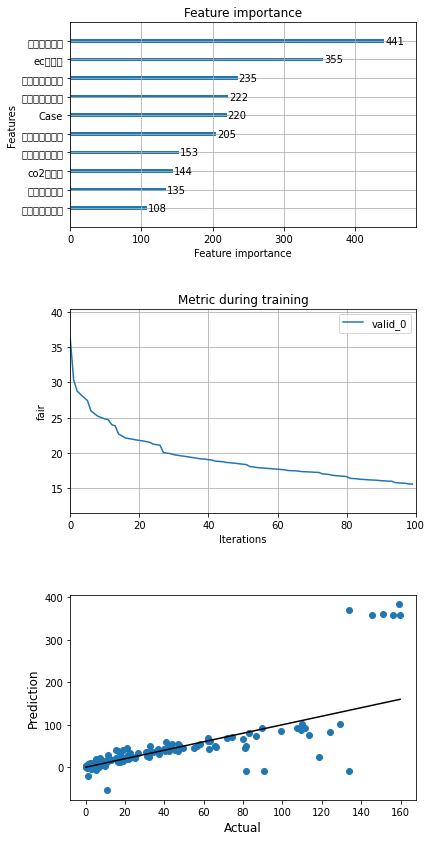

Features Importance Split & Gain...
    feature  split       gain
2   내부온도관측치    205  25.549958
7   시간당백색광량    153  16.516389
8   시간당적색광량    235  14.251440
5     ec관측치    355  14.075436
6    시간당분무량    441  12.134507
4    co2관측치    144   4.840277
1      Case    220   4.073667
3   내부습도관측치    222   3.790530
10   시간당총광량    135   2.319647
0       DAT    100   1.816200
9   시간당청색광량    108   0.631949
MAE: 97976792787120869959711763013940056230786912443786017878172788396093296647394054774207599994449220073662307924660525251504972837417674317669935021805886857080209408.000, MSE:    inf, RMSE:    inf


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_regression.py:442: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_regression.py:442: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)


In [ ]:
import matplotlib.pyplot as plt
def plot_results(model, evals_result, test_Y, pred_test_y):
    """
    학습된 모델(model)의 평가결과(evals_result)를 표시한다.
    """
    fig, axes = plt.subplots(3, figsize=(8,12))
    fig.subplots_adjust(hspace=.4)

    lgb.plot_importance(model, max_num_features=10, ax=axes[0])                 # 첫번째 그래프: 상위 10개의 피처 중요도

    lgb.plot_metric(evals_result, metric=METRIC, ax=axes[1])                    # 두번째 그래프: metric 측정 결과

    axe = axes[2]                                                               # 세번째 그래프: 실측치와 예측치의 상관도
    axe.scatter(test_Y, pred_test_y)
    axe.plot([test_Y.min(), test_Y.max()], [test_Y.min(), test_Y.max()], color='k')
    axe.set_xlabel('Actual', size=12)
    axe.set_ylabel('Prediction', size=12)

    plt.subplots_adjust(top=0.96, bottom=0.06, left=0.3)
    plt.show()

    print("Features Importance Split & Gain...")
    gain = model.feature_importance('gain')
    featureimp = pd.DataFrame({'feature':model.feature_name(), 
                    'split':model.feature_importance('split'), 
                    'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    print(featureimp[:50])
    return


#max_bin = tuning_max_bin(train_x,train_y)
train_x, train_y, val_x, val_y, tst_x, tst_y = load_spilit_train(train_x,train_y)

params = {'max_bin':2047, "verbose" : -1}                                    # warning 메시지를 표시하지 않도록 한다.
model, evals_result, fi, cv_preds = run_lgb(params, train_x, train_y, val_x, val_y, tst_x, tst_y)
plot_results(model, evals_result, tst_y, cv_preds['prediction'])

test_Y = np.expm1(tst_y)
pred_Y = np.expm1(cv_preds['prediction'])

MAE = mean_absolute_error(test_Y, pred_Y)
MSE = mean_squared_error(test_Y, pred_Y)
RMSE = np.sqrt(mean_squared_error(test_Y, pred_Y))

print(f"MAE: {MAE:6.3f}, MSE: {MSE:6.3f}, RMSE: {RMSE:6.3f}")

In [ ]:
#max_bin = tuning_max_bin()
max_bin = 2047
#train_x, train_y = load_train()
train_x = save_train
test_x = svae_test
RepNo = 5                                                                     # 품목 갯수


pred_Y = model.predict(test_x)                                          # 두번째 부터는 학습된 모델로 추론만 한다.

predict['predicted_weight_g'] = pred_Y

test_target_path = '/content/drive/MyDrive/상추/test_target/*.csv'
all_target_list = sorted(glob.glob(test_target_path))

i=0
for test_path in all_target_list:
    submit_df = pd.read_csv(test_path)
    submit_df['predicted_weight_g'] = predict['predicted_weight_g'][i*28:i*28+28].values
    print(submit_df,i)
    submit_df.to_csv(test_path, index=False)
    i+=1

    DAT  predicted_weight_g
0     1            1.586217
1     2            1.532667
2     3            1.765668
3     4           -1.122647
4     5           -2.388947
5     6            9.591258
6     7            8.377445
7     8           -0.517700
8     9            4.380762
9    10            3.093411
10   11            7.440768
11   12           10.406772
12   13           16.544636
13   14           14.480500
14   15           20.400469
15   16           22.901854
16   17           32.242781
17   18           28.422598
18   19           30.067738
19   20           30.950042
20   21           35.943370
21   22           38.823700
22   23           50.233863
23   24           48.358921
24   25           68.006250
25   26          108.588201
26   27          118.523057
27   28          119.169410 0
    DAT  predicted_weight_g
0     1            1.549166
1     2            1.783523
2     3            1.412974
3     4            5.673309
4     5            8.827950
5     6           